In [1]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas_datareader import data
from dask.distributed import Client
from dask.distributed import as_completed
import openpyxl
import xlsxwriter
import pandas_datareader.data as web
import statsmodels.tsa.stattools as ts
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import pandas_market_calendars as mcal
import os
import sqlite3
import matplotlib.pyplot as plt
import dataframe_image as dfi
import seaborn as sns
import scipy.stats as stats
import pickle

import datetime as dt

import scipy

import sys

import os

path = os.getcwd()

print(path)

C:\Users\User\Documents\wiki\wiki\dev\python\Python-Stock\code\Screener\code


In [2]:

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
def trend_tau(set_):
    [x1, x2] = set_
    tau, p_value = stats.kendalltau(x1,x2)
    return([tau,p_value])


In [4]:
def split_sequences(sequences, n_steps_in):

    X = list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        # check if we are beyond the dataset
        # gather input and output parts of the pattern
        seq_x = sequences[i:end_ix, :]
        X.append(seq_x)

    return np.array(X)

In [5]:
def highlight_cells(cell):
    #def inner(cell):
    color = 'green' if cell == True else ''
    return 'background-color: {}'.format(color)
    #return inner

In [6]:
end_ = datetime.today()
#start = end - relativedelta(years=2) - relativedelta(days=3)
start_ = end_ - relativedelta(months=64)
start_X2_ = end_ - relativedelta(months=64*2)

nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start_, end_date=end_)

nyse_X2 = mcal.get_calendar('NYSE')
nyse_dates_X2 = nyse.schedule(start_date=start_X2_, end_date=end_)

start = nyse_dates.index[0]
start_X2 = nyse_dates_X2.index[0]

end = nyse_dates.index[-1]
print(start.strftime('%Y-%m-%d'))
print(end.strftime('%Y-%m-%d'))

#used for trend
n_trend = 50

2017-03-31
2022-07-29


In [7]:
"""
db_filename = '.\\data\\interim\\todo.db'

db_is_new = not os.path.exists(db_filename)

conn = sqlite3.connect(db_filename)

if db_is_new:
    print('Need to create schema')
else:
    print('Database exists, assume schema does, too.')

conn.close()
"""

"\ndb_filename = '.\\data\\interim\\todo.db'\n\ndb_is_new = not os.path.exists(db_filename)\n\nconn = sqlite3.connect(db_filename)\n\nif db_is_new:\n    print('Need to create schema')\nelse:\n    print('Database exists, assume schema does, too.')\n\nconn.close()\n"

In [8]:
dict_sectors = {'Basic Materials':'VAW', 'Communication Services':'VOX', 'Consumer Cyclical':'VCR',
       'Consumer Defensive':'VDC', 'Energy':'VDE', 'Financial Services':'VFH', 'Healthcare':'VHT',
       'Industrials':'VIS', 'Real Estate':'VNQ', 'Technology':'VGT', 'Utilities':'VPU', 'error':'error'}

dict_indexes = {'SPTM':'SP1500', 'SPY':'SP500', 'SLY':'SP600', 'MDYG':'SP400','error':'error'}

invert_dict_indexes = {v: k for k, v in dict_indexes.items()}

dict_sectors_reverse = {'VAW':'Basic Materials',
 'VOX':'Communication Services',
 'VCR':'Consumer Cyclical',
 'VDC':'Consumer Defensive',
 'VDE':'Energy',
 'VFH':'Financial Services',
 'VHT':'Healthcare',
 'VIS':'Industrials',
 'VNQ':'Real Estate',
 'VGT':'Technology',
 'VPU':'Utilities',
 'error': 'error'}

In [9]:
index_names = ['SP1500', 'SP500', 'SP600', 'SP400']
indexes = ['SPTM','SPY','SLY','MDYG']
sector_names = ['Communication Services ETF', 'Consumer Discretionary ETF', 'Consumer Staples ETF', 'Energy ETF', 'Financials ETF', 'Health Care ETF', 'Industrials ETF', 'Information Technology ETF', 'Materials ETF', 'Real Estate ETF', 'Utilities ETF']
sectors = ['VOX','VCR','VDC','VDE','VFH','VHT','VIS','VGT','VAW','VNQ','VPU']

etf_bonds = ['LQD', 'AGG', 'NEAR', 'IUSB', 'ISTB', 'IMTB', 'ILTB', 'GBF']
etf_muni_bonds = ['MUB', 'SUB', 'MEAR']

etf_treasuries = ['AGZ', 'GOVT', 'BIL', 'SHV', 'SHY', 'IEI', 'IEF', 'TLT']

#M1_MONEY_MULTIPLIER = M1NS/BOGMBASE

FRED_Indicators = [
"ASPUS",\
"AWHAETP",\
"B432RG3A086NBEA",\
"BAA10Y",\
"BACDINA066MNFRBNY",\
"BACTSAMFRBDAL",\
"BAMLC0A0CM",\
"BAMLCC0A1AAATRIV",\
"BAMLCC0A4BBBTRIV",\
"BAMLH0A3HYC",\
"BAMLHYH0A0HYM2TRIV",\
"BOGMBASE",\
"BOGZ1FA105015103Q",\
"BOGZ1FA145050005Q",\
"BOGZ1FA205050005Q",\
"BOGZ1FA315050005Q",\
"BOGZ1FA385050005Q",\
"BOGZ1FL105015105Q",\
"BUSAPPWNSACA",\
"BUSLOANS",\
"CASTHPI",\
"CES0500000003",\
"CES4348400001",\
"CFNAI",\
"CFNAIDIFF",\
"CFSBCACTIVITYMFG",\
"CILACBQ158SBOG",\
"CIVPART",\
"COMREPUSQ159N",\
"CONSUMER",\
"CP",\
"CPALTT01USQ657N",\
"CPIAUCSL",\
"CSCICP03USM665S",\
"CSUSHPINSA",\
"CUSR0000SEHA",\
"CUUR0000SEHA",\
"DALLCIACBEP",\
"DCOILBRENTEU",\
"DCOILWTICO",\
"DEXCHUS",\
"DEXUSUK",\
"DFF",\
"DFII10",\
"DGORDER",\
"DGS1",\
"DGS10",\
"DGS1MO",\
"DGS2",\
"DGS30",\
"DGS3MO",\
"DGS5",\
"DRBLACBS",\
"DRCCLACBS",\
"DRSFRMACBS",\
"DGS3MO",\
"DTWEXBGS",\
"EMRATIO",\
"ERENTUSQ176N",\
"ETOTALUSQ176N",\
"FEDFUNDS",\
"FGCCSAQ027S",\
"FPCPITOTLZGUSA",\
"GASREGW",\
"GDPC1",\
"GFDEBTN",\
"GFDEGDQ188S",\
"GOLDAMGBD228NLBM",\
"GVZCLS",\
"HDTGPDUSQ163N",\
"HOSMEDUSM052N",\
"IC4WSA",\
"ICSA",\
"IIPUSNETIQ",\
"INDPRO",\
"INTDSRUSM193N",\
"IRLTLT01USM156N",\
"KCFSI",\
"LES1252881600Q",\
"LEU0252918500Q",\
"LFWA64TTUSM647S",\
"LRUN64TTUSQ156S",\
"LXXRCSA",\
"M1",\
"M1V",\
"M1NS",\
"M2V",\
"MABMM301USM189S",\
"MANMM101USA189S",\
"MEFAINUSA672N",\
"MEHOINUSA672N",\
"MEPAINUSA672N",\
"MICH",\
"MOGMBASE",\
"MORTGAGE30US",\
"MPRIME",\
"MSPUS",\
"MVMTD027MNFRBDAL",\
"MZMSL",\
"NEWORDER",\
"NFCI",\
"NROU",\
"NYSTHPI",\
"PAYEMS",\
"PCE",\
"PERMIT",\
"POP",\
"POPTOTUSA647NWDB",\
"PPIACO",\
"PRFI",\
"PSAVERT",\
"Q10096USQ144NNBR",\
"RECPROUSM156N",\
"RSAHORUSQ156S",\
"SPCS20RSA",\
"STLFSI2",\
"T10Y2Y",\
"T10Y3M",\
"T10YIE",\
"T5YIE",\
"T5YIFR",\
"TB3MS",\
"TCU",\
"TDSP",\
"TEDRATE",\
"TOTALSA",\
"TREAST",\
"TTLHH",\
"TWEXB",\
"UMCSENT",\
"U6RATE",\
"UNRATE",\
"USALOLITONOSTSAM",\
"USPHCI",\
"USREC",\
"USROA",\
"USROE",\
"USSLIND",\
"USSTHPI",\
"VIXCLS",\
"VXVCLS",\
"WDFUELLA",\
"WGS3MO",\
"WILLLRGCAPVAL",\
"WILLMICROCAPPR",\
"WPU0911",\
"WPUSI019011",\
"WPU101",\
"WTB3MS"    
]

#volume
dict_treasury = {
'SP500': 'ES=F',\
'T bill Euro F':  'GE=F',\
'Two Year T F': 'ZT=F',\
'Ten Year T F': 'ZN=F'
}

#TVV
currencies = ['EURUSD=X','GBPUSD=X','AUDUSD=X','BRLUSD=X','JPY=X','GE=F','ZAR=X','CNYUSD=X']

#doesn't work ,'B0=F'

indexes_futures = ['^RUT','^IRX','^GSPC']

#'SIL=F','MGC=F','RTY=F'
other_commodities_list = ['UUP','YM=F','NQ=F','ZB=F','ZF=F','BZ=F','ZO=F','KE=F','ZR=F','ZM=F','ZL=F','GF=F','CT=F','LBS=F','OJ=F']


#price
#currencies = ['EURUSD=X','GBPUSD=X','AUDUSD=X','BRLUSD=X','JPY=X','GE=F']

dict_foods = {
'Corn': 'ZC=F',\
'Soybeans': 'ZS=F',\
'Chicago Wheat': 'ZW=F',\
'Live Cattle': 'LE=F',\
'Lean Hogs': 'HE=F',\
'Cocoa': 'CC=F',\
'Sugar': 'SB=F',\
'Coffee': 'KC=F'\
}



#price
dict_metals = {'Gold': 'GC=F',\
'Platinum':  'PL=F',\
'Palladium': 'PA=F',\
'Silver': 'SI=F',\
'Copper':  'HG=F',\
'Aluminium': 'ALI=F'
}



#price
dict_energy = {
'Crude Oil':  'CL=F',\
'Heating Oil': 'HO=F',\
'Natural Gas': 'NG=F',\
'RB Gasoline': 'RB=F'
}

etf_bonds = [*etf_bonds,*etf_muni_bonds,*etf_treasuries]

In [10]:
SP500ticker_list = pd.read_html('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
SP600ticker_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[1]
SP400ticker_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[0]


In [11]:
sp500 = SP500ticker_list['Symbol']
sp500 = [w.replace('.', '-') for w in sp500]
sp600 = SP600ticker_list['Ticker symbol']
sp600 = [w.replace('.', '-') for w in sp600]
sp400 = SP400ticker_list['Ticker symbol']
sp400 = [w.replace('.', '-') for w in sp400]


In [12]:
len(sp500)+len(sp600)+len(sp400)

1505

In [13]:
print(len(sp500))
SP1500 = list()
SP1500.extend(sp500)
sp600 = list(set(sp600).difference(SP1500))
print(len(sp600))
SP1500.extend(sp600)
sp400 = list(set(sp400).difference(SP1500))
print(len(sp400))
SP1500.extend(set(sp400).difference(SP1500))

503
601
401


In [14]:
#>.5The time series is mean reverting
#=.5 time series is a Geometric Brownian Motion
#<.5 time series is trending

def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts

    Parameters
    ----------
    ts : `numpy.array`
        Time series upon which the Hurst Exponent will be calculated

    Returns
    -------
    'float'
        The Hurst Exponent from the poly fit output
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [15]:
sp1500_index_df = pd.DataFrame()

lists = ["sp500","sp600","sp400"]

for l in lists:
    if(l=='sp500'):
        df = pd.DataFrame(sp500,columns=['Symbol'])
        print(len(df))
        #range_ = 
        #print(range_)
        df['Market Index'] = pd.Series(["SP500" for x in range(0,len(df.index),1)])
    elif(l=='sp600'):
        df = pd.DataFrame(np.array(sp600),columns=['Symbol'])        
        print(len(df))        
        df['Market Index'] = pd.Series(["SP600" for x in range(len(df.index))])
        df.index = range(len(sp500),(len(sp500)+len(df.index)),1)        
    else:
        df = pd.DataFrame(np.array(sp400),columns=['Symbol'])
        print(len(df))
        df['Market Index'] = pd.Series(["SP400" for x in range(len(df.index))])
        df.index = range((len(sp500)+len(sp600)),(len(sp500)+len(sp600)+len(df.index)),1)
    sp1500_index_df = pd.concat([sp1500_index_df,df],axis=0)

503
601
401


In [16]:
len(sp1500_index_df)-len(SP1500)

0

In [17]:
def Fred_Data(npa):
    name = npa[0]
    start_ = npa[1]
    end_ = npa[2]
    nyse_dates_ = npa[3]
    
    temp = web.DataReader(str(name), 'fred', start_, end_)
    #temp = web.DataReader(npa[1][0],'fred',start,end)
    temp = temp.asfreq('D').interpolate(method='time',limit_direction='forward',limit_area='inside').reindex(nyse_dates_.index)
    temp.columns = ['Value']
    #temp.index = pd.to_datetime(temp.index)
    
    #temp['Symbol'] = name
    
    #print(temp)
    #temp_new = temp.asfreq('D').interpolate(method='time')    
    temp_dates = pd.date_range(temp.index[0].strftime('%Y-%m-%d'), temp.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
    nyse_inbetween_temp_dates = nyse_dates_.index[(nyse_dates_.index >= temp_dates[0]) & (nyse_dates_.index <= temp_dates[-1])]
    temp_new = temp.reindex(nyse_inbetween_temp_dates)
    temp_new['Symbol'] = name
    
    #temp = temp.resample(frequency).mean().dropna()
    return(temp_new)
    #return(temp)

In [18]:

def dl(npa):
    name = npa[0]
    start_ = npa[1]
    end_ = npa[2]
    nyse_dates_ = npa[3]
    subset = yf.download(name, start=start_, end=end_, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    
    temp_new = subset.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates_.index)
    temp_dates = pd.date_range(subset.index[0].strftime('%Y-%m-%d'), subset.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
    nyse_inbetween_temp_dates = nyse_dates_.index[(nyse_dates_.index >= temp_dates[0]) & (nyse_dates_.index <= temp_dates[-1])]
    temp_new = temp_new.reindex(nyse_inbetween_temp_dates)
    subset_ = temp_new
    subset_['Symbol'] = name

    return (subset_)
    
def dl2(assets):

    yahoo_financials = YahooFinancials(assets)

    data = yahoo_financials.get_historical_price_data(start_date=start_date.strftime('%Y-%m-%d'), end_date=end_date.strftime('%Y-%m-%d'), time_interval='daily')
    return(data)

In [19]:
def getStock(npa):
    symbol = npa[0]
    start_=npa[1]
    end_=npa[2]
    
    data_ = yf.download(symbol, start=start_,end=end_)
  
    return([symbol,data_])

In [20]:
def getTickerData(npa):
    symbol = npa[0]
    
    stock_data = yf.Ticker(symbol) 
    return([symbol,stock_data])

In [21]:
def getSector(npa):
    #position = npa[0]
    symbol = npa[0]
    #start_=npa[2]
    #end_=npa[3]
    
    tickerdata = yf.Ticker(symbol)
    
    if 'sector' in tickerdata.info:
        sector = tickerdata.info['sector']
    else:
        sector = 'error'

    if 'industry' in tickerdata.info:
        industry = tickerdata.info['industry']
    else:
        industry = 'error'

    return([symbol,sector,industry])

In [22]:
def derive_price_supply_trends(npa_):
    name = npa_[0]
    data = npa_[1]
    nyse_dates_ = npa_[2]
        
    temp_new = data.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates_.index)
    temp_dates = pd.date_range(data.index[0].strftime('%Y-%m-%d'), data.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
    nyse_inbetween_temp_dates = nyse_dates_.index[(nyse_dates_.index >= temp_dates[0]) & (nyse_dates_.index <= temp_dates[-1])]
    temp_new = temp_new.reindex(nyse_inbetween_temp_dates)
    
    data_ = temp_new
    data_['risk_50td_trend'] = (data.shift(50)-data)/ ((data.rolling(50).max()-data.rolling(50).min()) /4) 
    data_['Symbol'] = name
    return(data_)
    

In [23]:
def derive_tvv(npa_):
    name = npa_[0]
    data = npa_[1]
    #print(data)
    nyse_dates_ = npa_[2]
        
    temp_new = data.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates_.index)
    temp_dates = pd.date_range(data.index[0].strftime('%Y-%m-%d'), data.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
    nyse_inbetween_temp_dates = nyse_dates_.index[(nyse_dates_.index >= temp_dates[0]) & (nyse_dates_.index <= temp_dates[-1])]
    temp_new = temp_new.reindex(nyse_inbetween_temp_dates)
    
    data_ = temp_new
    data_['Symbol'] = name

    """
    if(np.sum(duplicates==names_prices[n])>0):
        #potential duplicate
        if((np.sum((np.unique(prices_df['Symbol']))==n))>0):
            pass
        else:
            prices_df = pd.concat([prices_df,data_],axis=0)            
    else:
    """
    
    data_['VWAP'] = (data_['Adj Close']*data_['Volume'])
    
    data_['buy_volume_pct'] = (data_['Adj Close']-data_['Low'])/(data_['High']-data_['Low'])
    data_['sell_volume_pct'] = (data_['Adj Close']-data_['High'])/(data_['High']-data_['Low'])



    data_['daily_buy_vol'] = data_['buy_volume_pct']*data_['Volume']
        
        
    
    data_['daily_sell_vol'] = data_['sell_volume_pct']*data_['Volume']
    
    data_['net_daily_vol'] = data_['daily_buy_vol']+data_['daily_sell_vol']
    
    data_['20td_trend_vol'] = data_['net_daily_vol'].rolling(20).sum()
    
    
    data_['20td_tot_daily_vol'] = data_['Volume'].rolling(20).sum()
    
    data_['20td_trend_vol_factor'] = data_['20td_trend_vol']/data_['20td_tot_daily_vol']
    
    data_['20td_tvf_rng_div_2'] = (data_['20td_trend_vol_factor'].rolling(20).max()-data_['20td_trend_vol_factor'].rolling(20).min())/2
    
    data_['20td_tvf_vel'] = data_['20td_trend_vol_factor']/data_['20td_tvf_rng_div_2']    
    
    
    data_['50td_trend_vol'] = data_['net_daily_vol'].rolling(20).sum()
    
    data_['50td_tot_daily_vol'] = data_['Volume'].rolling(20).sum()
    
    data_['50td_trend_vol_factor'] = data_['50td_trend_vol']/data_['50td_tot_daily_vol']
    
    data_['50td_tvf_rng_div_4'] = (data_['50td_trend_vol_factor'].rolling(20).max()-data_['50td_trend_vol_factor'].rolling(20).min())/4
    
    data_['50td_tvf_vel'] = data_['50td_trend_vol_factor']/data_['50td_tvf_rng_div_4']    
    
    
    data_['trailing_1yr_max'] = (pd.DataFrame(data_)['High']).rolling(252).max()
    data_['MIN_Lookback_One_Year'] = data_['trailing_1yr_max'].rolling(252).min()
    #data_['MIN_Lookback_6_Months'] = data_['trailing_1yr_max'].rolling(126).min()
    data_['MIN_Lookback_2_Months'] = data_['trailing_1yr_max'].rolling(42).min()
    data_['MIN_Lookback_1_Months'] = data_['trailing_1yr_max'].rolling(21).min()

    data_['trailing_1yr_min'] = (pd.DataFrame(data_)['Low']).rolling(252).min()
    
    data_['supply_trend_1yr'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(252).min()
    
    #data_['supply_trend_180d'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(126).min()
    
    #data_['supply_trend_200td'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(63).min()
    
    data_['supply_trend_60d'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(42).min()
    
    data_['supply_trend_30d'] = pd.DataFrame(data_)['Adj Close']-(pd.DataFrame(data_)['High']).rolling(21).min()

    data_['trailing_60d_max'] = (pd.DataFrame(data_)['High']).rolling(42).max()
    data_['trailing_60d_min'] = (pd.DataFrame(data_)['Low']).rolling(42).min()
    
    data_['trailing_30d_max'] = (pd.DataFrame(data_)['High']).rolling(21).max()
    data_['trailing_30d_min'] = (pd.DataFrame(data_)['Low']).rolling(21).min()
    
    data_['200tdSMA'] = (pd.DataFrame(data_)['Adj Close']).rolling(200).mean()
    
    data_['200tdSDev'] = (pd.DataFrame(data_)['Adj Close']).rolling(200).std()
    
    data_['TP'] = (data_['Adj Close'] + data_['Low'] + data_['High'])/3
    data_['50tdstdTP'] = data_['TP'].rolling(50).std(ddof=0)
    data_['50tdMA-TP'] = data_['TP'].rolling(50).mean()
    data_['50tdBOLU'] = data_['50tdMA-TP'] + 2*data_['50tdstdTP']
    data_['50tdBOLD'] = data_['50tdMA-TP'] - 2*data_['50tdstdTP']    

    data_['trailing_risk_40d_max'] = (pd.DataFrame(data_)['High']).rolling(40).max()
    data_['trailing_risk_40d_min'] = (pd.DataFrame(data_)['Low']).rolling(40).min()
    
    data_['risk_per_share'] = data_['trailing_risk_40d_max']-data_['trailing_risk_40d_min']
    

    data_['30d_vol'] = (pd.DataFrame(data_)['Volume']).rolling(21).sum()
        
    data_['30d_vol_2yr'] = data_['30d_vol'].rolling(512).mean()
    data_['volume_factor'] = data_['30d_vol']/data_['30d_vol_2yr']
    
    #data_['1YMF'] = (data_['Adj Close']-data_['MIN_Lookback_One_Year']) + (data_['Adj Close']-data_['MIN_Lookback_6_Months']) + (data_['Adj Close']-data_['MIN_Lookback_2_Months']) + (data_['Adj Close']-data_['MIN_Lookback_1_Months'])
    data_['1YMF'] = (data_['Adj Close']-data_['MIN_Lookback_One_Year']) + (data_['Adj Close']-data_['MIN_Lookback_2_Months']) + (data_['Adj Close']-data_['MIN_Lookback_1_Months'])
    
    data_['risk_trend_factor'] = data_['1YMF']/data_['risk_per_share']
    
    return(data_)

In [24]:
def calculateMetrics(data_):

    df_line = data_[['Symbol','buy_volume_pct','sell_volume_pct','daily_buy_vol','daily_sell_vol','net_daily_vol','20td_trend_vol','20td_tot_daily_vol','20td_trend_vol_factor','20td_tvf_rng_div_2','20td_tvf_vel','50td_trend_vol','50td_tot_daily_vol','50td_trend_vol_factor','50td_tvf_rng_div_4','50td_tvf_vel','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','risk_per_share','volume_factor','Adj Close','50tdBOLD','50tdMA-TP','50tdBOLU','200tdSMA','200tdSDev']].iloc[[-1]].reset_index().set_index('Symbol')
    name = df_line.index[0]
    adf = ts.adfuller(data_['Adj Close'].tail(n_trend).values)[1]

    hurst_ = hurst(data_['Adj Close'].tail(n_trend).values)    

    data = data_['Adj Close'].tail(n_trend)
    dates = [pd.to_datetime(d).value for d in data.index]

    dates = np.array(dates)-np.array(dates[0])/10**11

    int_date_data = pd.concat([pd.DataFrame(dates),pd.DataFrame(data.values)],axis=1)

    trend_t = [*[trend_tau([pd.DataFrame(int_date_data.iloc[:,0]).values,data.values])]]

    tau = trend_t[0][0]
    tau_p = trend_t[0][1]

    try:
        adf = ts.adfuller(data_['Adj Close'].tail(n_trend).values)[1]
    except:
        adf = 'error'

    try:
        hurst_ = hurst(data_['Adj Close'].tail(n_trend).values)
    except:
        hurst_ = 'error'

    temp = pd.concat([df_line,pd.DataFrame([adf],index=[name],columns=['adf_50td']),pd.DataFrame([tau],index=[name],columns=['tau_50td']),pd.DataFrame([tau_p],index=[name],columns=['tau_50td_p']),pd.DataFrame([hurst_],index=[name],columns=['hurst_50td'])],axis=1)
    temp.columns = ['Date',*temp.columns[1:]]
    temp

    return(temp)
    

In [25]:
def extractTickerValues(npa):
    
    n_ = npa[0]
    r_ = npa[1]
    #print(r_)
    print(n_)

    subset = pd.DataFrame([r_.info])

    others = ['quarterly_balance_sheet','quarterly_cashflow','quarterly_dividends','quarterly_earnings','quarterly_financials','mutualfund_holders','options','sustainability']

    o_items = []

    #print(r_)
    for o in others:
        if(np.sum(np.array(dir(r_))==[o])>0):
            o_item = getattr(r_, o)
            o_items.append([o,o_item])            

    
    values = pd.DataFrame()

    trackers = ['shortName','beta','currentRatio','debtToEquity','dividendRate','dividendYield','earningsGrowth','earningsQuarterlyGrowth','ebitda','ebitdaMargins','exDividendDate','forwardEPS','forwardPE','freeCashflow','grossMargins','grossProfits','heldPercentInstitutions','industry','lastDividendDate','lastDividendValue','lastSplitDate','lastSplitFactor','marketCap','operatingCashflow','operatingMargins','payoutRatio','pegRatio','priceToBook','priceToSalesTrailing12Months','profitMargins','quickRatio','returnOnAssets','returnOnEquity','revenueGrowth','revenuePerShare','sector','sharesOutstanding','shortRatio','totalAssets','totalCash','totalCashPerShare','totalDebt','totalRevenue','trailingEPS','trailingAnnualDividendRate','trailingAnnualDividendYield','trailingPE']

    for t in trackers:
        if(np.sum(np.where(subset.columns==t))==0):
            values = pd.concat([values,pd.DataFrame('error',index=[n_],columns=[t])],axis=1)
        else:
            values = pd.concat([values,pd.DataFrame(subset[t].values[0],index=[n_],columns=[t])],axis=1)

    return([n_,values,o_items])

In [26]:
tvv_extracted_list = np.unique([*indexes_futures,*other_commodities_list,*[dict_foods[d] for d in dict_foods],*currencies,*[dict_treasury[d] for d in dict_treasury],*[dict_metals[d] for d in dict_metals],*[dict_energy[d] for d in dict_energy]])
npa = []
for f in tvv_extracted_list:
    npa.append([f,start_X2,end])

print("npa length:getStock(commodites)"len(npa))

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()
future = client.map(getStock, npa)
results_commodities_futures = []
#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        results_commodities_futures.append("error")
    else:
        results_commodities_futures.append(f.result()) 
client.close()

"""
data_['trailing_risk_40d_max'] = (pd.DataFrame(data_)['High']).rolling(40).max()
data_['trailing_risk_40d_min'] = (pd.DataFrame(data_)['Low']).rolling(40).min()
"""

C:\Users\User\AppData\Local\Programs\3.9-JupyterLab\lib\site-packages\distributed\client.py:1131: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| blosc   | 1.10.6 | None      | None    |
| lz4     | 4.0.2  | 3.1.10    | 3.1.10  |
| numpy   | 1.23.1 | 1.22.4    | 1.22.4  |
| tornado | 6.2    | 6.1       | 6.1     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


"\ndata_['trailing_risk_40d_max'] = (pd.DataFrame(data_)['High']).rolling(40).max()\ndata_['trailing_risk_40d_min'] = (pd.DataFrame(data_)['Low']).rolling(40).min()\n"

In [27]:
#price_list = [*currencies,*[dict_treasury[d] for d in dict_treasury],*[dict_metals[d] for d in dict_metals],*[dict_energy[d] for d in dict_energy]]


In [28]:
names_comm_results = [r[0] for r in results_commodities_futures]
sum_comm_tvv_volume = [np.sum(r[1]['Volume']) for r in results_commodities_futures]

In [29]:
no_volume_comm = np.array(names_comm_results)[np.array(sum_comm_tvv_volume)==0]


In [30]:
#other_commodities_list_df[other_commodities_list_df['Symbol']=='ALI=F']

In [31]:
list_comm_output = [pd.DataFrame(r[1]) for r in results_commodities_futures]
list_comm_prices = [r[0] for r in results_commodities_futures]
dict_comm_prices = dict(zip(*[list_comm_prices,list_comm_output])) 


In [32]:
"""
full_commodities_price_df_pvt = pd.DataFrame()

for r_df in results_commodities_futures:

        temp_df = r_df[1].asfreq('D').interpolate(method='time',limit_direction='forward',limit_area='inside').reindex(nyse_dates_X2.index)
        temp_dates = pd.date_range(temp_df.index[0].strftime('%Y-%m-%d'), temp_df.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
        nyse_inbetween_temp_dates = nyse_dates_X2.index[(nyse_dates_X2.index >= temp_dates[0]) & (nyse_dates_X2.index <= temp_dates[-1])]
        temp_new = temp_df.reindex(nyse_inbetween_temp_dates)
        #temp_new['Symbol'] = r_df[0]
        price = temp_new[['Adj Close']]
        price.columns = [r_df[0]]
        print(price)
        full_commodities_price_df_pvt = pd.concat([price.copy(),full_commodities_price_df_pvt],axis=1)
        
#full_commodities_df_pvt = pd.pivot_table(full_commodities_df_pvt, values=['Adj Close'], index=other_commodities_list_df.index,columns=['Symbol'])
#full_commodities_df_pvt.columns = full_commodities_df_pvt.columns.droplevel(0)        
"""

"\nfull_commodities_price_df_pvt = pd.DataFrame()\n\nfor r_df in results_commodities_futures:\n\n        temp_df = r_df[1].asfreq('D').interpolate(method='time',limit_direction='forward',limit_area='inside').reindex(nyse_dates_X2.index)\n        temp_dates = pd.date_range(temp_df.index[0].strftime('%Y-%m-%d'), temp_df.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))\n        nyse_inbetween_temp_dates = nyse_dates_X2.index[(nyse_dates_X2.index >= temp_dates[0]) & (nyse_dates_X2.index <= temp_dates[-1])]\n        temp_new = temp_df.reindex(nyse_inbetween_temp_dates)\n        #temp_new['Symbol'] = r_df[0]\n        price = temp_new[['Adj Close']]\n        price.columns = [r_df[0]]\n        print(price)\n        full_commodities_price_df_pvt = pd.concat([price.copy(),full_commodities_price_df_pvt],axis=1)\n        \n#full_commodities_df_pvt = pd.pivot_table(full_commodities_df_pvt, values=['Adj Close'], index=other_commodities_list_df.index,columns=['Symbol'])

In [33]:

price_comm_df_pvt = pd.DataFrame()

for d in dict_comm_prices:
    temp = dict_comm_prices[d]
    temp['Symbol'] = d
    price_comm_df_pvt = pd.concat([price_comm_df_pvt,temp],axis=0)

price_comm_df_pvt = pd.pivot_table(price_comm_df_pvt, values=['Adj Close'], index=price_comm_df_pvt.index,columns=['Symbol'])
#price_comm_df_pvt.columns = price_comm_df_pvt.columns.droplevel(0)
#price_comm_df_pvt.columns = [d for d in dict_comm_prices]

price_comm_df_10_yr_pvt = price_comm_df_pvt.dropna(axis=1, thresh = int(0.95*price_comm_df_pvt.shape[0]))
price_comm_df_10_yr_pvt.columns = price_comm_df_10_yr_pvt.columns.droplevel(0)
price_comm_df_5_yr_pvt = price_comm_df_pvt.tail(int(len(price_comm_df_10_yr_pvt)/2))
price_comm_df_5_yr_pvt = price_comm_df_5_yr_pvt.dropna(axis=1, thresh = int(0.95*price_comm_df_5_yr_pvt.shape[0]))
price_comm_df_5_yr_pvt.columns = price_comm_df_5_yr_pvt.columns.droplevel(0)

price_comm_df_10_yr_pvt_corr = price_comm_df_10_yr_pvt.asfreq('D').interpolate(method='time').asfreq('W-'+price_comm_df_10_yr_pvt.index[-1].strftime('%a')).corr()

price_comm_df_5_yr_pvt_corr = price_comm_df_5_yr_pvt.asfreq('D').interpolate(method='time').asfreq('W-'+price_comm_df_5_yr_pvt.index[-1].strftime('%a')).corr()





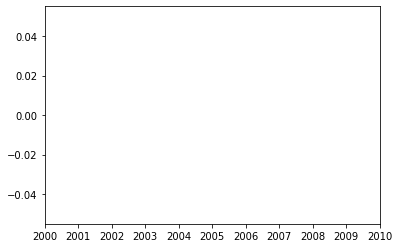

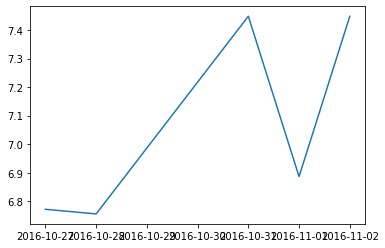

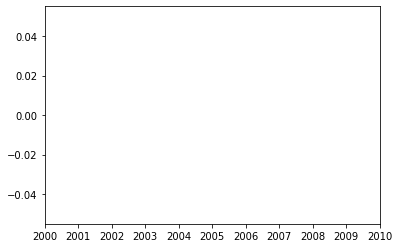

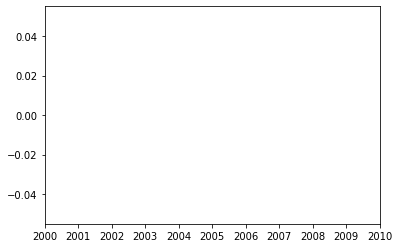

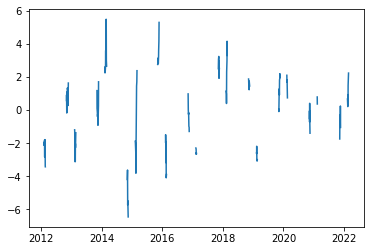

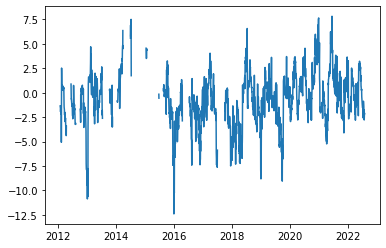

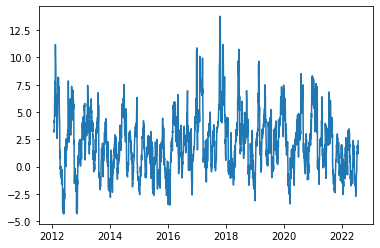

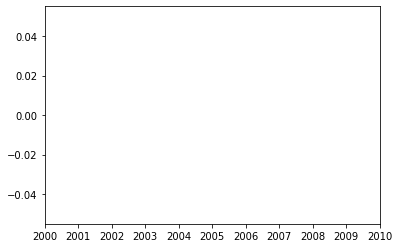

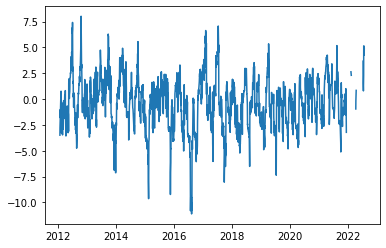

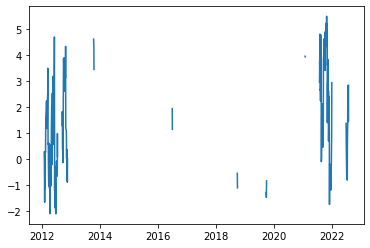

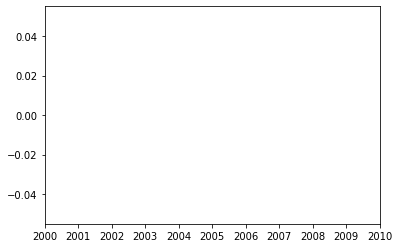

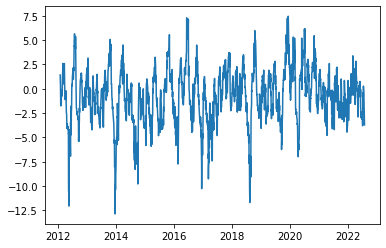

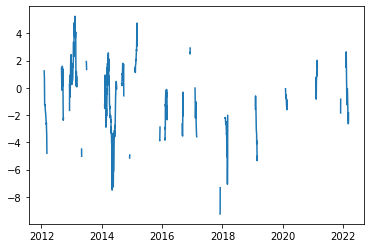

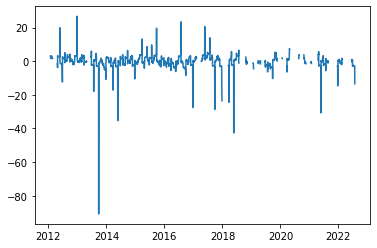

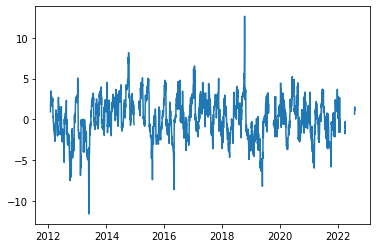

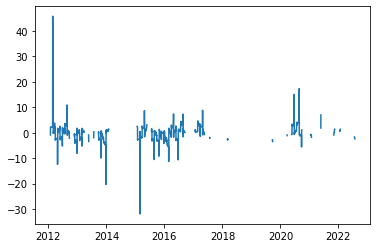

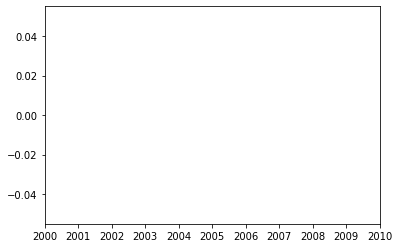

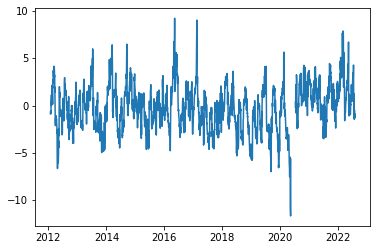

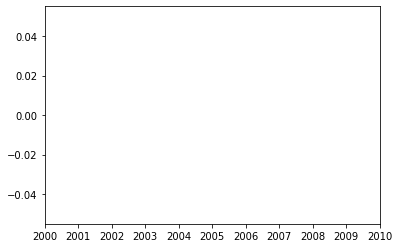

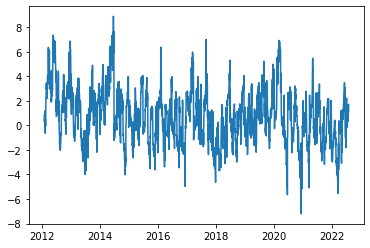

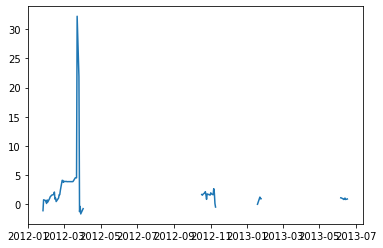

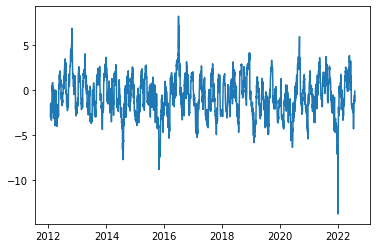

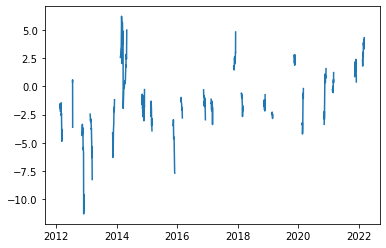

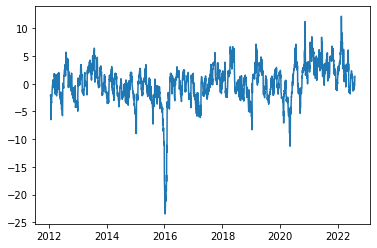

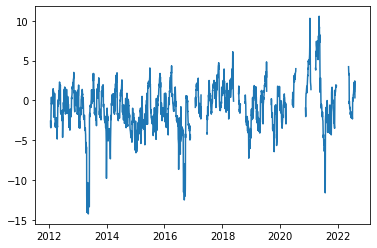

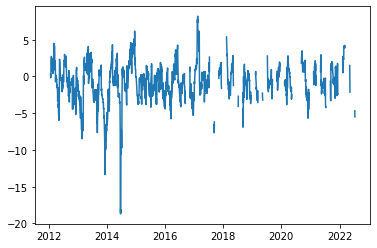

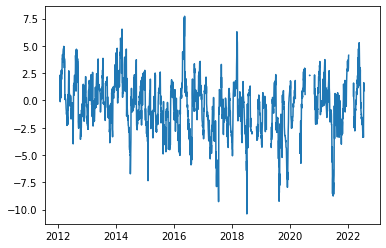

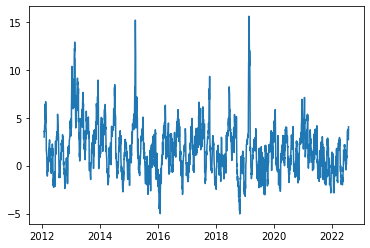

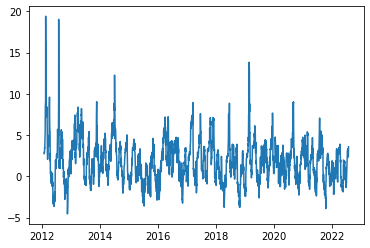

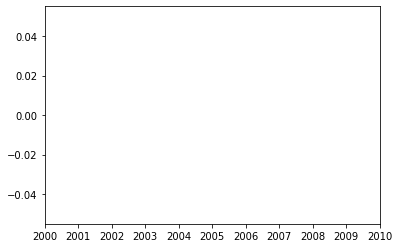

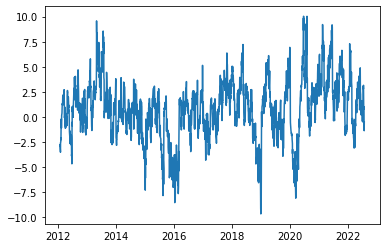

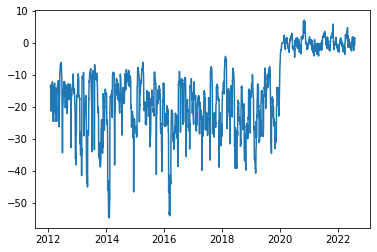

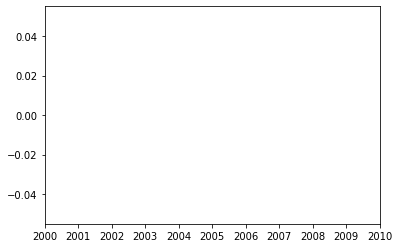

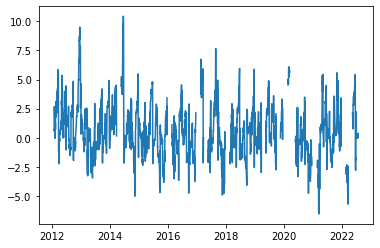

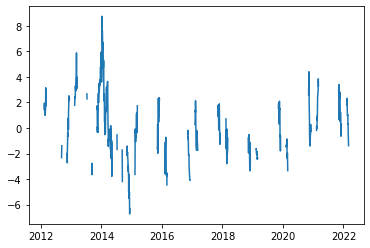

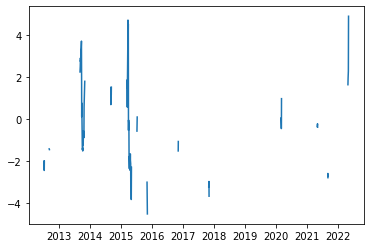

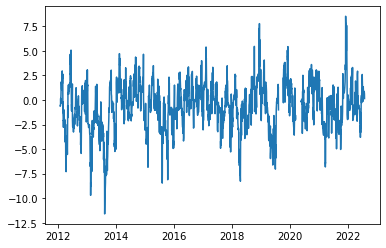

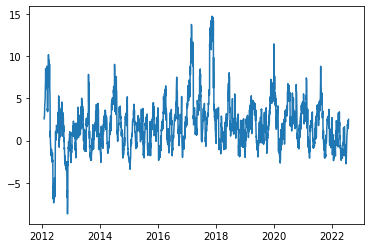

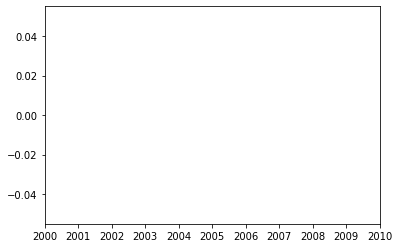

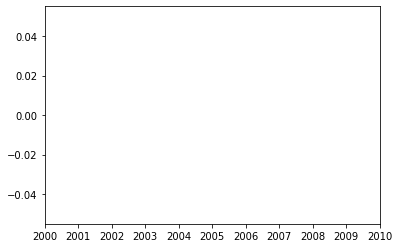

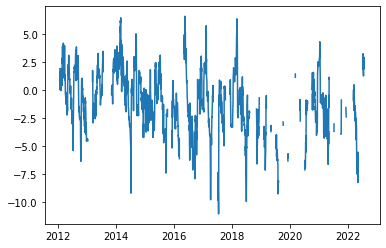

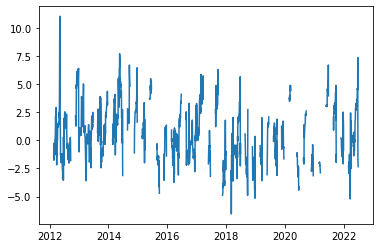

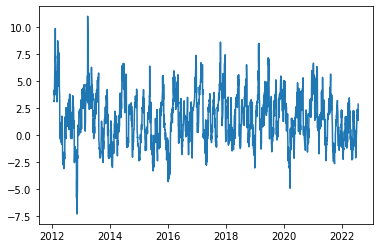

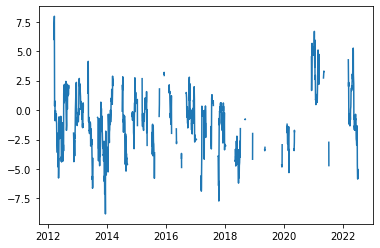

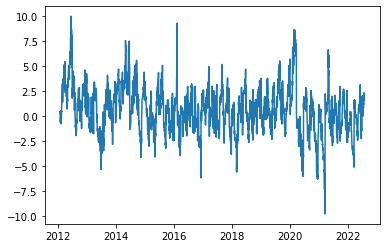

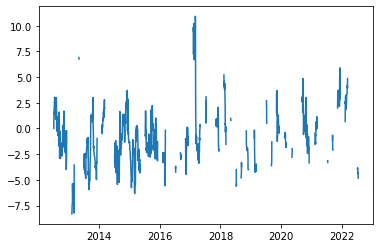

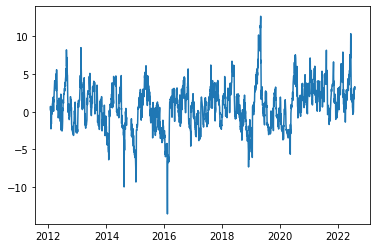

In [34]:

for d in [d for d in dict_comm_prices]:
    #print(d)
    plt.plot(derive_tvv([d,dict_comm_prices[d],nyse_dates_X2])[['50td_tvf_vel']])
    plt.show()
    #d = dict_comm_prices[d][0]
    #print(d)

In [35]:
"""
#d= [d for d in dict_comm_prices][0]
comm_tvv_df_pvt = pd.DataFrame()

for d in [d for d in dict_comm_prices]:
    #print(d)    
    test = derive_tvv([d,dict_comm_prices[d],nyse_dates_X2])[['50td_tvf_vel']]
        
    #if(np.sum(dict_comm_p
    if(abs(np.sum(test))[0]>0):
        if((len(test.dropna()))<int(0.5*test.shape[0])):
            temp = derive_price_supply_trends([d,dict_comm_prices[d][['Adj Close']],nyse_dates_X2])[['risk_50td_trend']]
        else:
            temp = derive_tvv([d,dict_comm_prices[d],nyse_dates_X2])[['50td_tvf_vel']]            
    else:
        temp = derive_price_supply_trends([d,dict_comm_prices[d][['Adj Close']],nyse_dates_X2])[['risk_50td_trend']]
    
    temp.columns = [d]
    
    temp = temp.asfreq('D').interpolate().asfreq('W-'+end.strftime('%a'))
        
    comm_tvv_df_pvt = pd.concat([comm_tvv_df_pvt,temp],axis=1)
"""

"\n#d= [d for d in dict_comm_prices][0]\ncomm_tvv_df_pvt = pd.DataFrame()\n\nfor d in [d for d in dict_comm_prices]:\n    #print(d)    \n    test = derive_tvv([d,dict_comm_prices[d],nyse_dates_X2])[['50td_tvf_vel']]\n        \n    #if(np.sum(dict_comm_p\n    if(abs(np.sum(test))[0]>0):\n        if((len(test.dropna()))<int(0.5*test.shape[0])):\n            temp = derive_price_supply_trends([d,dict_comm_prices[d][['Adj Close']],nyse_dates_X2])[['risk_50td_trend']]\n        else:\n            temp = derive_tvv([d,dict_comm_prices[d],nyse_dates_X2])[['50td_tvf_vel']]            \n    else:\n        temp = derive_price_supply_trends([d,dict_comm_prices[d][['Adj Close']],nyse_dates_X2])[['risk_50td_trend']]\n    \n    temp.columns = [d]\n    \n    temp = temp.asfreq('D').interpolate().asfreq('W-'+end.strftime('%a'))\n        \n    comm_tvv_df_pvt = pd.concat([comm_tvv_df_pvt,temp],axis=1)\n"

In [36]:
#comm_tvv_df_pvt = pd.pivot_table(comm_tvv_df, values=['50td_tvf_vel'], index=comm_tvv_df.index,columns=['Symbol'])
#comm_tvv_df_pvt.columns = comm_tvv_df_pvt.columns.droplevel(0)
"""
comm_tvv_df_10_yr_pvt = comm_tvv_df_pvt.dropna(axis=1, thresh = int(0.95*comm_tvv_df_pvt.shape[0]))
comm_tvv_df_5_yr_pvt = comm_tvv_df_pvt.tail(int(len(comm_tvv_df_10_yr_pvt)/2))
comm_tvv_df_5_yr_pvt = comm_tvv_df_5_yr_pvt.dropna(axis=1, thresh = int(0.95*comm_tvv_df_5_yr_pvt.shape[0]))
"""

'\ncomm_tvv_df_10_yr_pvt = comm_tvv_df_pvt.dropna(axis=1, thresh = int(0.95*comm_tvv_df_pvt.shape[0]))\ncomm_tvv_df_5_yr_pvt = comm_tvv_df_pvt.tail(int(len(comm_tvv_df_10_yr_pvt)/2))\ncomm_tvv_df_5_yr_pvt = comm_tvv_df_5_yr_pvt.dropna(axis=1, thresh = int(0.95*comm_tvv_df_5_yr_pvt.shape[0]))\n'

In [37]:
"""
comm_tvv_df_10_yr_pvt_corr = comm_tvv_df_10_yr_pvt.asfreq('D').interpolate(method='time').asfreq('W-'+comm_tvv_df_10_yr_pvt.index[-1].strftime('%a')).corr()
comm_tvv_df_5_yr_pvt_corr = comm_tvv_df_5_yr_pvt.asfreq('D').interpolate(method='time').asfreq('W-'+comm_tvv_df_5_yr_pvt.index[-1].strftime('%a')).corr()
"""

"\ncomm_tvv_df_10_yr_pvt_corr = comm_tvv_df_10_yr_pvt.asfreq('D').interpolate(method='time').asfreq('W-'+comm_tvv_df_10_yr_pvt.index[-1].strftime('%a')).corr()\ncomm_tvv_df_5_yr_pvt_corr = comm_tvv_df_5_yr_pvt.asfreq('D').interpolate(method='time').asfreq('W-'+comm_tvv_df_5_yr_pvt.index[-1].strftime('%a')).corr()\n"

In [73]:
writer = pd.ExcelWriter('..\\reports\\'+end.strftime('%Y-%m-%d')+'_correlations.xlsx', engine='xlsxwriter')



In [39]:

#price_comm_df_10_yr_pvt_corr.to_excel(writer, sheet_name='price_comm_df_10_yr_pvt_corr')
#price_comm_df_5_yr_pvt_corr.to_excel(writer, sheet_name='price_comm_df_5_yr_pvt_corr')

#future_commodities_price_pvt = pd.pivot_table(commodity_prices, values=['Adj Close'], index=commodity_prices.index,columns=['Symbol'])
#future_commodities_price_pvt.columns = future_commodities_price_pvt.columns.droplevel(0)

In [74]:


#METALS CORRELATION MATRIX doing the same thing with (1) 50 day price change and (2) 50 day TVV.  Please run them all against each other to complete the METALS correlation matrix.  Run a 5 year and 10 year Matrix

#future_commodities_price_pvt_corr = future_commodities_price_pvt.corr().replace([np.NaN],0)

#future_commodities_50td_tvv_pvt.columns = full_commodities_df_pvt.columns.droplevel(0)

#'MVMTD027MNFRBDAL'
#check_corr_list = ['^GSPC','DGS3MO','DGS2','DGS10']
#check_corr_list = [dict_metals[d] for d in dict_metals]

"""
for c_c in check_corr_list:
    #inside = future_commodities_50td_tvv_pvt_corr.sort_values(by=c_c,ascending=False,axis=0).sort_values(by=c_c,ascending=False,axis=1)
    inside = comm_tvv_df_10_yr_pvt[dict_metals[d] for d in dict_metals].corr().sort_values(by=c_c,ascending=False,axis=0).sort_values(by=c_c,ascending=False,axis=1)
    plt.figure(figsize=(24,15))
    sns.heatmap(inside,cmap="RdYlGn",annot=True)
    plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'-'+c_c+'comm_tvv_df_10_yr_pvt_corr.png', dpi=300, format='png', bbox_inches='tight')
    plt.show()
    
"""


price_comm_df_10_yr_pvt_corr[price_comm_df_10_yr_pvt_corr.columns.intersection([dict_metals[d] for d in dict_metals])].corr().to_excel(writer, sheet_name='price_comm_metals_10_yr_corr')
price_comm_df_5_yr_pvt_corr[price_comm_df_5_yr_pvt_corr.columns.intersection([dict_metals[d] for d in dict_metals])].corr().to_excel(writer, sheet_name='price_comm_metals_5_yr_corr')

In [75]:
price_comm_df_10_yr_pvt_corr[set[price_comm_df_10_yr_pvt_corr.columns].intersection(set(currencies))].corr().to_excel(writer, sheet_name='price_comm_curr_10_yr_corr')
price_comm_df_5_yr_pvt_corr[set[price_comm_df_5_yr_pvt_corr.columns].intersection(set(currencies))].corr().to_excel(writer, sheet_name='price_comm_curr_5_yr_corr')

In [76]:
price_comm_df_10_yr_pvt_corr[price_comm_df_10_yr_pvt_corr.columns.intersection([*[dict_treasury[d] for d in dict_treasury], *[dict_metals[d] for d in dict_metals], *currencies, *[dict_energy[d] for d in dict_energy],*[dict_foods[d] for d in dict_foods], *indexes_futures, *other_commodities_list])].corr().to_excel(writer, sheet_name='price_comm_treasury_10_yr_corr')
price_comm_df_5_yr_pvt_corr[price_comm_df_5_yr_pvt_corr.columns.intersection([*[dict_treasury[d] for d in dict_treasury], *[dict_metals[d] for d in dict_metals], *currencies, *[dict_energy[d] for d in dict_energy],*[dict_foods[d] for d in dict_foods], *indexes_futures, *other_commodities_list])].corr().to_excel(writer, sheet_name='price_comm_treasury_5_yr_corr')



In [77]:
price_comm_df_10_yr_pvt_corr[price_comm_df_10_yr_pvt_corr.columns.intersection([dict_foods[d] for d in dict_foods])].corr().to_excel(writer, sheet_name='price_comm_foods_10_yr_corr')
price_comm_df_5_yr_pvt_corr[price_comm_df_5_yr_pvt_corr.columns.intersection([dict_foods[d] for d in dict_foods])].corr().to_excel(writer, sheet_name='price_comm_foods_5_yr_corr')

In [78]:
price_comm_df_10_yr_pvt_corr[price_comm_df_10_yr_pvt_corr.columns.intersection([dict_energy[d] for d in dict_energy])].corr().to_excel(writer, sheet_name='price_comm_energy_10_yr_corr')
price_comm_df_5_yr_pvt_corr[price_comm_df_5_yr_pvt_corr.columns.intersection([dict_energy[d] for d in dict_energy])].corr().to_excel(writer, sheet_name='price_comm_energy_5_yr_corr')

In [45]:
"""
price_comm_df_10_yr_pvt_corr.to_excel(writer, sheet_name='price_comm_df_10_yr_pvt_corr')
price_comm_df_5_yr_pvt_corr.to_excel(writer, sheet_name='comm_t')
pd.DataFrame(sp400).to_excel(writer, sheet_name='SP400')
pd.DataFrame(market_data).to_excel(writer, sheet_name='Stock_Fundamentals')
completed_fred_pvt.to_excel(writer, sheet_name='completed_fred_pvt')
completed_bonds.to_excel(writer, sheet_name='completed_bonds')
completed_bonds_pvt.to_excel(writer, sheet_name='completed_bonds_pvt')
pd.DataFrame(pd.DataFrame(sectors,sector_names)).to_excel(writer, sheet_name='vanguard_sectors')
pd.DataFrame(pd.DataFrame(indexes,index_names)).to_excel(writer, sheet_name='spdr_indexes')
screener_metrics.to_excel(writer, sheet_name='Screener')

writer.save()

wb = openpyxl.load_workbook('SP1500_screener_multiple.xlsx')
#openpyxl.Workbook()
new_range = openpyxl.workbook.defined_name.DefinedName('Prices', attr_text='SP1500_Sectors_Indexes_Prices!$A$1:$H$'+str(len(prices_df)+1))
wb.defined_names.append(new_range)
new_range = openpyxl.workbook.defined_name.DefinedName('SP1500', attr_text='SP1500!$B$1:$C$'+str(len(sp1500_index_df)+1))
wb.defined_names.append(new_range)
new_range = openpyxl.workbook.defined_name.DefinedName('Vanguard_Sectors', attr_text='vanguard_sectors!$B$1:$C$'+str(len(sectors)+1))
wb.defined_names.append(new_range)
new_range = openpyxl.workbook.defined_name.DefinedName('SPDR_Indexes', attr_text='spdr_indexes!$B$1:$C$'+str(len(indexes)+1))
wb.defined_names.append(new_range)


#wb.defined_names.append(new_range)
wb.save('SP1500_screener_multiple.xlsx')
wb.close()
#named_range = NamedRange("test_nr", [(new_sheet, "A1")])
#wb.add_named_range(new_range)
wb.close()
writer.close()
"""
"""
workbook = xlsxwriter.Workbook('SP1500_screener_multiple.xlsx')
workbook.define_name('Prices', '=SP1500Prices!$A$1:$J$'+str(len(prices_df)+1))
workbook.define_name('Sectors', '=stock_sectors!$A$1:$B$'+str(len(sectors_df)+1))
workbook.define_name('market_caps', '=market_caps!$A$1:$B$'+str(len(mktcap_df)+1))
workbook.define_name('SP1500', '=SP1500!$B$1:$C$'+str(len(sp1500_index_df)+1))

workbook.close()
"""

"\nworkbook = xlsxwriter.Workbook('SP1500_screener_multiple.xlsx')\nworkbook.define_name('Prices', '=SP1500Prices!$A$1:$J$'+str(len(prices_df)+1))\nworkbook.define_name('Sectors', '=stock_sectors!$A$1:$B$'+str(len(sectors_df)+1))\nworkbook.define_name('market_caps', '=market_caps!$A$1:$B$'+str(len(mktcap_df)+1))\nworkbook.define_name('SP1500', '=SP1500!$B$1:$C$'+str(len(sp1500_index_df)+1))\n\nworkbook.close()\n"

In [46]:
#TVV

"""
tvv_corr_set = np.unique([*[dict_treasury[d] for d in dict_treasury],*[d for d in other_commodities_list],*[d for d in indexes_futures]])
"""

'\ntvv_corr_set = np.unique([*[dict_treasury[d] for d in dict_treasury],*[d for d in other_commodities_list],*[d for d in indexes_futures]])\n'

In [47]:
"""
list1_as_set = set(tvv_corr_set)

intersection = comm_tvv_df_10_yr_pvt_corr.columns.intersection(list1_as_set)
intersection_as_list = list(intersection)

comm_tvv_df_10_yr_pvt_corr.loc[intersection_as_list][intersection_as_list].to_excel(writer, sheet_name='comm_tvv_10_yr_corr')

list1_as_set = set(tvv_corr_set)
intersection = comm_tvv_df_5_yr_pvt_corr.columns.intersection(list1_as_set)
intersection_as_list = list(intersection)

comm_tvv_df_5_yr_pvt_corr.loc[intersection_as_list][intersection_as_list].to_excel(writer, sheet_name='comm_tvv_5_yr_corr')

"""

"\nlist1_as_set = set(tvv_corr_set)\n\nintersection = comm_tvv_df_10_yr_pvt_corr.columns.intersection(list1_as_set)\nintersection_as_list = list(intersection)\n\ncomm_tvv_df_10_yr_pvt_corr.loc[intersection_as_list][intersection_as_list].to_excel(writer, sheet_name='comm_tvv_10_yr_corr')\n\nlist1_as_set = set(tvv_corr_set)\nintersection = comm_tvv_df_5_yr_pvt_corr.columns.intersection(list1_as_set)\nintersection_as_list = list(intersection)\n\ncomm_tvv_df_5_yr_pvt_corr.loc[intersection_as_list][intersection_as_list].to_excel(writer, sheet_name='comm_tvv_5_yr_corr')\n\n"

In [48]:
"""
list1_as_set = set(tvv_corr_set)
intersection = comm_tvv_df_10_yr_pvt_corr.columns.intersection(list1_as_set)
intersection_as_list = list(intersection)


for d in [d for d in dict_treasury]:
    #print(d)
    d = dict_treasury[d]
    print(d)
    
    inside_10 = comm_tvv_df_10_yr_pvt_corr[intersection_as_list].sort_values(by=d,ascending=False,axis=0).sort_values(by=d,ascending=False,axis=1)
    inside_5 = comm_tvv_df_5_yr_pvt_corr[intersection_as_list].sort_values(by=d,ascending=False,axis=0).sort_values(by=d,ascending=False,axis=1)
    
    inside_10[intersection_as_list].to_excel(writer, sheet_name=d+'_comm_tvv_10_yr_corr')
    inside_5[intersection_as_list].to_excel(writer, sheet_name=d+'_comm_tvv_5_yr_corr')

    #print('10 yr')
    #plt.figure(figsize=(24,15))
    #sns.heatmap(inside_10,cmap="RdYlGn",annot=True)
    #plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'-'+d+'price_comm_df_10_yr_pvt_corr.png', dpi=300, format='png', bbox_inches='tight')
    #plt.show()
    #print('5 yr')
    #plt.figure(figsize=(24,15))
    #sns.heatmap(inside_5,cmap="RdYlGn",annot=True)
    #plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'-'+d+'price_comm_df_5_yr_pvt_corr.png', dpi=300, format='png', bbox_inches='tight')
    #plt.show()
    
"""

"""    
for 
#price
#price_corr_set = 
[dict_energy[d] for d in dict_energy]
[dict_metals[d] for d in dict_metals]
[currencies[d] for d in currencies]

[dict_foods[d] for d in dict_foods]
"""

'    \nfor \n#price\n#price_corr_set = \n[dict_energy[d] for d in dict_energy]\n[dict_metals[d] for d in dict_metals]\n[currencies[d] for d in currencies]\n\n[dict_foods[d] for d in dict_foods]\n'

In [49]:
"""
tbill_3mo_df = Fred_Data(['DGS3MO',start_X2,end,nyse_dates_X2])[['Value']]
tbill_3mo_df.columns = ['DGS3MO']

tbill_2y_df = Fred_Data(['DGS2',start_X2,end,nyse_dates_X2])[['Value']]
tbill_2y_df.columns = ['DGS2']

tbill_10y_df = Fred_Data(['DGS10',start_X2,end,nyse_dates_X2])[['Value']]
tbill_10y_df.columns = ['DGS10']
"""

"\ntbill_3mo_df = Fred_Data(['DGS3MO',start_X2,end,nyse_dates_X2])[['Value']]\ntbill_3mo_df.columns = ['DGS3MO']\n\ntbill_2y_df = Fred_Data(['DGS2',start_X2,end,nyse_dates_X2])[['Value']]\ntbill_2y_df.columns = ['DGS2']\n\ntbill_10y_df = Fred_Data(['DGS10',start_X2,end,nyse_dates_X2])[['Value']]\ntbill_10y_df.columns = ['DGS10']\n"

In [50]:
"""
future_commodities_n_w_index_pvt_w_Fred = pd.concat([tbill_3mo_df,tbill_2y_df,tbill_10y_df,full_commodities_df_pvt],axis=1)
future_commodities_n_w_index_pvt_w_Fred.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_future_commodities_n_w_index_pvt_w_Fred.csv')
future_commodities_n_w_index_pvt_w_Fred.dropna(axis=1, thresh = int(.95*future_commodities_n_w_index_pvt_w_Fred.shape[0]), inplace=True)
"""

"\nfuture_commodities_n_w_index_pvt_w_Fred = pd.concat([tbill_3mo_df,tbill_2y_df,tbill_10y_df,full_commodities_df_pvt],axis=1)\nfuture_commodities_n_w_index_pvt_w_Fred.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_future_commodities_n_w_index_pvt_w_Fred.csv')\nfuture_commodities_n_w_index_pvt_w_Fred.dropna(axis=1, thresh = int(.95*future_commodities_n_w_index_pvt_w_Fred.shape[0]), inplace=True)\n"

In [51]:
#for c_c in check_corr_list:
    #future_commodities_50td_tvv_pvt = pd.concat([future_commodities_50td_tvv_pvt,future_commodities_n_w_index_pvt_w_Fred[[c_c]]],axis=1)


In [52]:
"""
future_commodities_50td_tvv_pvt_corr = future_commodities_50td_tvv_pvt.corr().replace([np.NaN],0)

#future_commodities_50td_tvv_pvt.columns = full_commodities_df_pvt.columns.droplevel(0)

#'MVMTD027MNFRBDAL'
#check_corr_list = ['^GSPC','DGS3MO','DGS2','DGS10']
check_corr_list = [dict_treasury[d] for d in dict_treasury]

for c_c in check_corr_list:
    #inside = future_commodities_50td_tvv_pvt_corr.sort_values(by=c_c,ascending=False,axis=0).sort_values(by=c_c,ascending=False,axis=1)
    inside = comm_tvv_df_10_yr_pvt.corr().sort_values(by=c_c,ascending=False,axis=0).sort_values(by=c_c,ascending=False,axis=1)
    plt.figure(figsize=(24,15))
    sns.heatmap(inside,cmap="RdYlGn",annot=True)
    plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'-'+c_c+'comm_tvv_df_10_yr_pvt_corr.png', dpi=300, format='png', bbox_inches='tight')
    plt.show()
"""

'\nfuture_commodities_50td_tvv_pvt_corr = future_commodities_50td_tvv_pvt.corr().replace([np.NaN],0)\n\n#future_commodities_50td_tvv_pvt.columns = full_commodities_df_pvt.columns.droplevel(0)\n\n#\'MVMTD027MNFRBDAL\'\n#check_corr_list = [\'^GSPC\',\'DGS3MO\',\'DGS2\',\'DGS10\']\ncheck_corr_list = [dict_treasury[d] for d in dict_treasury]\n\nfor c_c in check_corr_list:\n    #inside = future_commodities_50td_tvv_pvt_corr.sort_values(by=c_c,ascending=False,axis=0).sort_values(by=c_c,ascending=False,axis=1)\n    inside = comm_tvv_df_10_yr_pvt.corr().sort_values(by=c_c,ascending=False,axis=0).sort_values(by=c_c,ascending=False,axis=1)\n    plt.figure(figsize=(24,15))\n    sns.heatmap(inside,cmap="RdYlGn",annot=True)\n    plt.savefig(\'..\\reports\\figures\\\'+end.strftime(\'%Y-%m-%d\')+\'-\'+c_c+\'comm_tvv_df_10_yr_pvt_corr.png\', dpi=300, format=\'png\', bbox_inches=\'tight\')\n    plt.show()\n'

In [53]:
"""

check_corr_list = ['^GSPC','DGS3MO','DGS2','DGS10']

for c_c in check_corr_list:

    data = future_commodities_n_w_index_pvt_w_Fred[[c_c]]
    dates = [pd.to_datetime(d).value for d in data.index]

    dates = np.array(dates)-np.array(dates[0])/10**11

    int_date_data = pd.concat([pd.DataFrame(dates),pd.DataFrame(data[[c_c]].values)],axis=1)
    int_date_data.columns = ['Date',c_c]

    windows = split_sequences(int_date_data.values,n_trend)
    windows = pd.DataFrame(windows).head(-(n_trend-1)).values.ravel()        

    trend_t = [*[trend_tau([pd.DataFrame(d).iloc[:,0].values,pd.DataFrame(d).iloc[:,1].values]) for d in windows]]
    sp_w_trend = pd.concat([pd.DataFrame(data[c_c].values),pd.DataFrame(np.append(np.repeat(np.nan,len(data)-len([t[0] for t in trend_t])),[t[0] for t in trend_t])),pd.DataFrame(np.append(np.repeat(np.nan,len(data)-len([t[0] for t in trend_t])),[t[0] for t in trend_t]))],axis=1)
    sp_w_trend.columns = [c_c,'trending','p-value']
    sp_w_trend.index = data.index
    trending = sp_w_trend[['trending']]>0  
    #trending = pd.DataFrame((future_commodities_n_w_index_pvt_w_Fred[c_c]-future_commodities_n_w_index_pvt_w_Fred[c_c].shift(n_trend))>0)

    trending.columns = ['trending']
    trending_df = pd.concat([future_commodities_n_w_index_pvt_w_Fred,trending],axis=1)

    future_commodities_trending = trending_df[trending_df['trending']==True]
    future_commodities_not_trending = trending_df[trending_df['trending']!=True]

    sorted_by_c_future_commodities_corr = future_commodities_n_w_index_pvt_w_Fred.corr().sort_values(by=c_c,ascending=False,axis=0).sort_values(by=c_c,ascending=False,axis=1)
    sorted_by_c_future_commodities_corr.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'-'+c_c+'_sorted_by_c_future_commodities_corr.csv')

    future_commodities_trending_corr = future_commodities_trending.corr().sort_values(by=c_c,ascending=False,axis=0).sort_values(by=c_c,ascending=False,axis=1)
    sorted_by_c_future_commodities_corr.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'-'+c_c+'_future_commodities_trending_corr.csv')

    future_commodities_not_trending_corr = future_commodities_not_trending.corr().sort_values(by=c_c,ascending=False,axis=0).sort_values(by=c_c,ascending=False,axis=1)
    future_commodities_not_trending_corr.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'-'+c_c+'_future_commodities_not_trending_corr.csv')

    plt.figure(figsize=(24,15))
    sns.heatmap(future_commodities_n_w_index_pvt_w_Fred[sorted_by_c_future_commodities_corr.index].corr(),cmap="RdYlGn",annot=True)
    plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'-'+c_c+'_sorted_by_c_future_commodities_corr.png', dpi=300, format='png', bbox_inches='tight')
    #plt.show()

    fig, ax1 = plt.subplots( figsize=(15,6) )

    ax2 = ax1.twinx()

    ax1.plot(trending_df[[c_c]])
    ax2.plot(trending_df[['trending']])
    ax2.fill_between(trending_df.index, 0, 1, where=trending_df['trending'] == True,facecolor='blue', alpha=0.5)
    plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'-'+c_c+'_trending.png', dpi=300, format='png', bbox_inches='tight')
    #plt.show()

    print("correlations when trending")
    print(len(future_commodities_trending))

    sorted_future_commodities_trending = future_commodities_trending.corr()[[c_c]].sort_values(by=c_c,ascending=False)

    plt.figure(figsize=(24,15))
    sns.heatmap(future_commodities_trending[sorted_future_commodities_trending.index].corr(),cmap="RdYlGn",annot=True)
    plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'-'+c_c+'_sorted_by_c_future_commodities_trending_corr.png', dpi=300, format='png', bbox_inches='tight')
    #plt.show()

    print("correlations when not trending")
    print(len(future_commodities_not_trending))

    sorted_future_commodities_not_trending = future_commodities_not_trending.corr()[[c_c]].sort_values(by=c_c,ascending=False)

    plt.figure(figsize=(24,15))
    sns.heatmap(future_commodities_not_trending[sorted_future_commodities_not_trending.index].corr(),cmap="RdYlGn",annot=True)
    plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'-'+c_c+'_sorted_by_c_future_commodities_not_trending_corr.png', dpi=300, format='png', bbox_inches='tight')
    #plt.show()

    plt.figure(figsize=(4,5))
    sns.heatmap((sorted_future_commodities_not_trending-sorted_future_commodities_trending).sort_values(by=[c_c],ascending=False),cmap="RdYlGn",annot=True)
    plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'-'+c_c+'_sorted_by_c_future_commodities_trending-not_trending_corr.png', dpi=300, format='png', bbox_inches='tight')
    #plt.show()

    n = len(future_commodities_not_trending)

    dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
    p_not_trending = pd.DataFrame(2*dist.cdf(-abs(future_commodities_not_trending[sorted_future_commodities_not_trending.index].corr())),columns=future_commodities_not_trending.columns,index=sorted_future_commodities_not_trending.index)

    n = len(future_commodities_trending)

    dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
    p_trending = pd.DataFrame(2*dist.cdf(-abs(future_commodities_trending[sorted_future_commodities_trending.index].corr())),columns=future_commodities_trending.columns,index=sorted_future_commodities_trending.index)
    #p_trending = pd.DataFrame([2*dist.cdf(-abs(future_commodities_trending[sorted_future_commodities_trending.index].corr()))],columns=sorted_future_commodities_trending.columns,index=sorted_future_commodities_trending.index)


    temp_all_significant = pd.DataFrame((pd.DataFrame(p_not_trending)<.05)*(pd.DataFrame(p_trending)<.05)*(future_commodities_not_trending[sorted_future_commodities_not_trending.index].corr()*future_commodities_trending[sorted_future_commodities_trending.index].corr())>0)
    temp_all_significant_inverted = pd.DataFrame((pd.DataFrame(p_not_trending)<.05)*(pd.DataFrame(p_trending)<.05)*(future_commodities_not_trending[sorted_future_commodities_not_trending.index].corr()*future_commodities_trending[sorted_future_commodities_trending.index].corr())<0)
    temp_trend_significant = pd.DataFrame(pd.DataFrame(p_trending)<.05)
    temp_not_trend_significant = pd.DataFrame(pd.DataFrame(p_not_trending)<.05)

    combined = pd.concat([temp_trend_significant.loc[[c_c]].T,temp_not_trend_significant.loc[[c_c]].T,temp_all_significant.loc[[c_c]].T,temp_all_significant_inverted.loc[[c_c]].T],axis=1)
    combined.columns = ['trend','not_trend','both','inverted']
    df_styled = combined.style.applymap(highlight_cells)
    #display(df_styled)
    #with HiddenPrints():
    dfi.export(df_styled, '..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'-'+c_c+'_corr_styled.png'
"""

'\n\ncheck_corr_list = [\'^GSPC\',\'DGS3MO\',\'DGS2\',\'DGS10\']\n\nfor c_c in check_corr_list:\n\n    data = future_commodities_n_w_index_pvt_w_Fred[[c_c]]\n    dates = [pd.to_datetime(d).value for d in data.index]\n\n    dates = np.array(dates)-np.array(dates[0])/10**11\n\n    int_date_data = pd.concat([pd.DataFrame(dates),pd.DataFrame(data[[c_c]].values)],axis=1)\n    int_date_data.columns = [\'Date\',c_c]\n\n    windows = split_sequences(int_date_data.values,n_trend)\n    windows = pd.DataFrame(windows).head(-(n_trend-1)).values.ravel()        \n\n    trend_t = [*[trend_tau([pd.DataFrame(d).iloc[:,0].values,pd.DataFrame(d).iloc[:,1].values]) for d in windows]]\n    sp_w_trend = pd.concat([pd.DataFrame(data[c_c].values),pd.DataFrame(np.append(np.repeat(np.nan,len(data)-len([t[0] for t in trend_t])),[t[0] for t in trend_t])),pd.DataFrame(np.append(np.repeat(np.nan,len(data)-len([t[0] for t in trend_t])),[t[0] for t in trend_t]))],axis=1)\n    sp_w_trend.columns = [c_c,\'trending\',\'

In [54]:
#(pd.DataFrame(p_not_trending)<.05)
#(pd.DataFrame(p_trending)<.05)

In [55]:
#test

dates = []
for d in pd.read_csv('..\\data\\raw\\sample.csv')['Date']:
    dates.append(dt.datetime.strptime(d, '%d-%b-%y'))

temp = pd.read_csv('..\\data\\raw\\sample.csv',thousands=",")
temp.index = dates
temp = temp.iloc[:,1:]
temp.columns = ['Open','High','Low','Adj Close','Volume']
#temp['Close'] = temp['Close'].astype(float)
temp.sort_index(inplace=True)
temp['Symbol'] = 'Test'

temp_new = derive_tvv(['temp',temp,nyse_dates]).sort_index(ascending=False)
temp_new.sort_index(inplace=True)
#display(temp_new)
#display(temp_new[['buy_volume_pct', 'sell_volume_pct', 'daily_buy_vol', 'daily_sell_vol', 'net_daily_vol', '20td_trend_vol', '20td_tot_daily_vol','20td_trend_vol_factor', '20td_tvf_rng_div_2', '20td_tvf_vel',  '50td_trend_vol', '50td_tot_daily_vol','50td_trend_vol_factor', '50td_tvf_rng_div_4', '50td_tvf_vel']])
#display(calculateMetrics(temp_new))
#


In [56]:
npa = []
for i in range(0,len([*SP1500,*indexes,*sectors])):
    npa.append([[*SP1500,*indexes,*sectors][i],start.strftime('%Y-%m-%d'),end.strftime('%Y-%m-%d')])
    
print("npa length:getStock(stocks)"len(npa))

# = getStock(npa[0])

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()
future = client.map(getStock, npa)
results_prices = []
#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        results_prices.append("error")
    else:
        results_prices.append(f.result()) 
client.close()


C:\Users\User\AppData\Local\Programs\3.9-JupyterLab\lib\site-packages\distributed\client.py:1131: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| blosc   | 1.10.6 | None      | None    |
| lz4     | 4.0.2  | 3.1.10    | 3.1.10  |
| numpy   | 1.23.1 | 1.22.4    | 1.22.4  |
| tornado | 6.2    | 6.1       | 6.1     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [57]:
npa = []
for i in range(0,len([*SP1500,*indexes,*sectors])):
    npa.append([[*SP1500,*indexes,*sectors][i]])
    
print("npa length:getTickerData"len(npa))

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(getTickerData, npa)

results_ticker_data = []

#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        results_ticker_data.append("error")
    else:
        results_ticker_data.append(f.result()) 
#client.restart()
client.close()


In [58]:
print(results_ticker_data[0][1].info)
print(results_ticker_data[0][1].quarterly_balance_sheet)
print(results_ticker_data[0][1].quarterly_cashflow)
#print(results_ticker_data[0][1].quarterly_dividends)
print(results_ticker_data[0][1].quarterly_earnings)
print(results_ticker_data[0][1].quarterly_financials)


{'zip': '45202', 'sector': 'Consumer Defensive', 'fullTimeEmployees': 101000, 'longBusinessSummary': 'The Procter & Gamble Company provides branded consumer packaged goods to consumers in North and Latin America, Europe, the Asia Pacific, Greater China, India, the Middle East, and Africa. It operates in five segments: Beauty; Grooming; Health Care; Fabric & Home Care; and Baby, Feminine & Family Care. The Beauty segment offers conditioners, shampoos, styling aids, and treatments; and antiperspirants and deodorants, personal cleansing, and skin care products under the Head & Shoulders, Herbal Essences, Pantene, Rejoice, Olay, Old Spice, Safeguard, Secret, and SK-II brands. The Procter & Gamble Company was founded in 1837 and is headquartered in Cincinnati, Ohio.', 'city': 'Cincinnati', 'phone': '513 983 1100', 'state': 'OH', 'country': 'United States', 'companyOfficers': [], 'website': 'https://www.pginvestor.com', 'maxAge': 1, 'address1': 'One Procter & Gamble Plaza', 'industry': 'Hous

In [59]:
results_ticker_data[0][1].info

{'zip': '45202',
 'sector': 'Consumer Defensive',
 'fullTimeEmployees': 101000,
 'longBusinessSummary': 'The Procter & Gamble Company provides branded consumer packaged goods to consumers in North and Latin America, Europe, the Asia Pacific, Greater China, India, the Middle East, and Africa. It operates in five segments: Beauty; Grooming; Health Care; Fabric & Home Care; and Baby, Feminine & Family Care. The Beauty segment offers conditioners, shampoos, styling aids, and treatments; and antiperspirants and deodorants, personal cleansing, and skin care products under the Head & Shoulders, Herbal Essences, Pantene, Rejoice, Olay, Old Spice, Safeguard, Secret, and SK-II brands. The Procter & Gamble Company was founded in 1837 and is headquartered in Cincinnati, Ohio.',
 'city': 'Cincinnati',
 'phone': '513 983 1100',
 'state': 'OH',
 'country': 'United States',
 'companyOfficers': [],
 'website': 'https://www.pginvestor.com',
 'maxAge': 1,
 'address1': 'One Procter & Gamble Plaza',
 'indu

In [60]:
npa = []
results_ticker_names = [r[0] for r in results_ticker_data]
for n in range(0,len(results_ticker_names),1):
    npa.append([results_ticker_names[n],results_ticker_data[n][1]])

In [ ]:

print("npa length:extractTickerValues"len(npa))  


In [61]:

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(extractTickerValues, npa)

results_ticker_values = []

#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        results_ticker_values.append("error")
    else:
        results_ticker_values.append(f.result()) 
client.close()

"""
trackers = ['beta','bookValue','currentRatio','debtToEquity','dividendRate','dividendYield','earningsGrowth','ebitda','ebitdaMargins','enterpriseValue','enterpriseToEbitda','enterpriseToRevenue','floatShares','forwardPE','freeCashflow','grossMargins','grossProfits','heldPercentInsiders','heldPercentInstitutions','impliedSharesOutstanding','industry','marketCap','operatingCashflow','operatingMargins','payoutRatio','pegRatio','priceToBook','priceToSalesTrailing12Months','profitMargins','quickRatio','returnOnAssets','returnOnEquity','revenueGrowth','revenuePerShare','sector','sharesOutstanding','sharesShort','sharesPercentSharesOut','sharesShortPreviousMonthDate','shortRatio','totalAssets','totalCash','totalCashPerShare','totalDebt','totalRevenue','trailingPE']

for t in trackers:
    if(np.sum(np.where(subset.columns==t))==0):
        values = pd.concat([values,pd.DataFrame('error',index=[n_],columns=[t])],axis=1)
    else:
        values = pd.concat([values,pd.DataFrame(subset[t].values[0],index=[n_],columns=[t])],axis=1)
"""

C:\Users\User\AppData\Local\Programs\3.9-JupyterLab\lib\site-packages\distributed\client.py:1131: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| blosc   | 1.10.6 | None      | None    |
| lz4     | 4.0.2  | 3.1.10    | 3.1.10  |
| numpy   | 1.23.1 | 1.22.4    | 1.22.4  |
| tornado | 6.2    | 6.1       | 6.1     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


"\ntrackers = ['beta','bookValue','currentRatio','debtToEquity','dividendRate','dividendYield','earningsGrowth','ebitda','ebitdaMargins','enterpriseValue','enterpriseToEbitda','enterpriseToRevenue','floatShares','forwardPE','freeCashflow','grossMargins','grossProfits','heldPercentInsiders','heldPercentInstitutions','impliedSharesOutstanding','industry','marketCap','operatingCashflow','operatingMargins','payoutRatio','pegRatio','priceToBook','priceToSalesTrailing12Months','profitMargins','quickRatio','returnOnAssets','returnOnEquity','revenueGrowth','revenuePerShare','sector','sharesOutstanding','sharesShort','sharesPercentSharesOut','sharesShortPreviousMonthDate','shortRatio','totalAssets','totalCash','totalCashPerShare','totalDebt','totalRevenue','trailingPE']\n\nfor t in trackers:\n    if(np.sum(np.where(subset.columns==t))==0):\n        values = pd.concat([values,pd.DataFrame('error',index=[n_],columns=[t])],axis=1)\n    else:\n        values = pd.concat([values,pd.DataFrame(subset[

In [62]:
 
ticker_values = pd.DataFrame()

pickle_dumps = []

for r in results_ticker_values:
    if(r=='error'):
        pass
        #pd.DataFrame(np.repeat('error', len(trackers), axis = None),index=)
    else:                
        #print(r[1])
        subset = pd.DataFrame(r[1])
        subset.index = [r[0]]
        #print(subset)
        ticker_values = pd.concat([ticker_values,subset],axis=0)
        pickle_dumps.append([r[0],r[2]])
        #ticker_values = pd.concat([ticker_values,pd.DataFrame(r[1],index=[r[0]])],axis=0)

pd.DataFrame(ticker_values)

pickle.dump(pickle_dumps, open('..\\data\\interim\\fundamental.pkl', 'wb'))

In [63]:
"""
missing_ticker_values = list(set([*SP1500,*indexes,*sectors]).difference([n for n in pd.DataFrame(ticker_values).index]))
print(missing_ticker_values)

for r in range(0,len(missing_ticker_values)):
    r_ = missing_ticker_values[r]
    temp = pd.DataFrame(np.array([r_,*np.repeat('missing',len(pd.DataFrame(ticker_values.columns)))])).T.set_index(0)
    temp.columns = ticker_values.columns
    #.set_index(0).iloc[[0]].columns))])
    ticker_values = pd.concat([ticker_values,temp],axis=0)
"""


"\nmissing_ticker_values = list(set([*SP1500,*indexes,*sectors]).difference([n for n in pd.DataFrame(ticker_values).index]))\nprint(missing_ticker_values)\n\nfor r in range(0,len(missing_ticker_values)):\n    r_ = missing_ticker_values[r]\n    temp = pd.DataFrame(np.array([r_,*np.repeat('missing',len(pd.DataFrame(ticker_values.columns)))])).T.set_index(0)\n    temp.columns = ticker_values.columns\n    #.set_index(0).iloc[[0]].columns))])\n    ticker_values = pd.concat([ticker_values,temp],axis=0)\n"

In [64]:
market_data = pd.concat([ticker_values])

In [65]:
names_prices = [rp[0] for rp in results_prices]

#def process_df(data_):
npa = []    
for n in range(0,len(names_prices)):
    #print(names_prices[n])
    n_ = names_prices[n]
    npa.append([n_,results_prices[n][1],nyse_dates])
    
print("npa length:derive_tvv"len(npa))

prices_df = pd.DataFrame()

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(derive_tvv, npa)
#results_sectors = []
#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        #results_sectors.append("error")
        pass
    else:
        #results_sectors.append(f.result())
        prices_df = pd.concat([f.result(),prices_df],axis=0)
client.close()

In [66]:

npa = []
for s in names_prices:
    #print(s)
    subset = prices_df.iloc[np.where(prices_df['Symbol']==s)]
    if(len(subset)==0):
        pass
    else:
        npa.append(subset)
        
print("npa length:calculateMetrics"len(npa))

screenerMetrics = []

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(calculateMetrics, npa)

#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        screenerMetrics.append("error")
    else:
        screenerMetrics.append(f.result()) 
client.close()



In [67]:
screener_metrics = pd.concat(screenerMetrics)

In [68]:

missing_screener_metrics = list(set([*SP1500,*indexes,*sectors]).difference([n for n in screener_metrics.index]))
print(missing_screener_metrics)

for r in range(0,len(missing_screener_metrics)):
    r_ = missing_screener_metrics[r]
    test = pd.DataFrame([np.repeat('missing',len(screener_metrics.columns))],index=[r_],columns=screener_metrics.columns)
    screener_metrics = pd.concat([screener_metrics,test],axis=0)

#pd.DataFrame(screener_metrics)

['JW-A']


In [69]:
#fundamentals_quarterlies = pickle.load(open('./fundamental.pkl', 'rb'))
fundamental_entries = [e[0] for e in pickle_dumps]#[e[0] for e in fundamentals_quarterlies]


In [70]:
#summary = pd.concat([prices_df[prices_df['Symbol']==name_][['Symbol','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','risk_per_share','volume_factor']].iloc[[-1]].reset_index().set_index('Symbol') for name_ in np.unique(prices_df['Symbol'].values)]).reset_index()

In [80]:

#threshold = 0 
#stock_fundamentals = market_data
#screener = screener_metrics
#stock_indexes = sp1500_index_df


#spdr_indexes = indexes
#spdr_indexes.columns=['Symbol']
#vanguard_sectors = sectors
#vanguard_sectors.columns=['Symbol']
screener_metrics_w_sp1500index = screener_metrics.reset_index().rename(columns={'index': 'Symbol'}).merge(sp1500_index_df,on='Symbol',how='left')

screener_metrics_w_sp1500index_good = screener_metrics_w_sp1500index[screener_metrics_w_sp1500index['50td_tvf_vel']!='missing']

#risk_trend_threshold = screener_metrics_w_sp1500index_good['50td_tvf_vel'].quantile(q=[threshold]).values[0]
stock_sectors = market_data['sector']

temp = stock_sectors.reset_index()
temp.columns = ['Symbol','Sector']
sector_merged = screener_metrics.reset_index().rename(columns={'index': 'Symbol'}).merge(temp, on='Symbol', how='right')
temp_sm = sector_merged.merge(sp1500_index_df, on='Symbol', how='left').set_index('Symbol')
#temp_sm.columns = ['risk_trend_factor', 'Sector', 'index']

temp_index_symbol_map = pd.concat([sp1500_index_df,pd.DataFrame([invert_dict_indexes[s] for s in sp1500_index_df['Market Index']])],axis=1)
temp_index_symbol_map.columns = ['Symbol','Market Index','Index Symbol']

index_sector_merged = temp_sm.merge(temp_index_symbol_map.iloc[:,[0,2]], on='Symbol', how='left')

"""
for spdr_ in range(0,len(indexes)):
    spdr__ = indexes[spdr_]
    #spdr__i = indexes[spdr_]
    #temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index_Symbol']] = spdr__
    """

"\nfor spdr_ in range(0,len(indexes)):\n    spdr__ = indexes[spdr_]\n    #spdr__i = indexes[spdr_]\n    #temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i\n    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index_Symbol']] = spdr__\n    "

In [81]:


sector_performance = []
for v in sectors:    
    #sector_performance.append([v,screener_metrics.loc[[v]]['risk_trend_factor'].values[0]])
    sector_performance.append([v,np.mean(index_sector_merged[index_sector_merged['Sector']==dict_sectors_reverse[v]]['50td_tvf_vel']),np.mean(index_sector_merged[index_sector_merged['Sector']==dict_sectors_reverse[v]]['20td_tvf_vel']),np.mean(index_sector_merged[index_sector_merged['Sector']==dict_sectors_reverse[v]]['risk_trend_factor'])])
temp_v = pd.concat([pd.DataFrame([dict_sectors_reverse[v] for v in sectors]),pd.DataFrame(sectors)],axis=1)
temp_v.columns = ['Sector','Symbol']
sectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','50td_tvf_vel','20td_tvf_vel','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='50td_tvf_vel',ascending=False)    
sectors_risk_sorted

,Symbol,50td_tvf_vel,20td_tvf_vel,risk_trend_factor,Sector
7,VGT,2.746788,1.373394,-5.282030,Technology
5,VHT,2.720494,1.360247,-6.094306,Healthcare
6,VIS,2.702709,1.351355,-3.908743,Industrials
1,VCR,2.559713,1.279856,-6.597469,Consumer Cyclical
0,VOX,2.181693,1.090846,-7.436288,Communication Services
2,VDC,1.993774,0.996887,-2.761489,Consumer Defensive
8,VAW,1.974739,0.987369,-3.448851,Basic Materials
3,VDE,1.875782,0.937891,-1.255442,Energy
4,VFH,1.843475,0.921738,-4.928236,Financial Services
10,VPU,1.741991,0.870995,-0.976764,Utilities


In [82]:
index_performance = []
for v in indexes:
    #index_performance.append([v,screener_metrics.loc[[v]]['20td_tvf_vel'].values[0]])
    if(v =='SPTM'):
        index_performance.append([v,np.nanmean(index_sector_merged['50td_tvf_vel'].replace(['error','missing'], np.nan))])
    else:
        index_performance.append([v,np.nanmean(index_sector_merged[index_sector_merged['Market Index']==dict_indexes[v]]['50td_tvf_vel'].replace(['error','missing'], np.nan))])
    
    
temp_i = pd.DataFrame(index_performance,index=indexes)
temp_i.columns = ['Symbol','50td_tvf_vel']
index_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','50td_tvf_vel'],index=[dict_indexes[i] for i in indexes]).sort_values(by='50td_tvf_vel',ascending=False).reset_index()
index_risk_sorted.columns = ['Index','Symbol','50td_tvf_vel']
index_risk_sorted

,Index,Symbol,50td_tvf_vel
0,SP600,SLY,2.448933
1,SP1500,SPTM,2.350519
2,SP500,SPY,2.292643
3,SP400,MDYG,2.258262


In [83]:
risk_screened = screener_metrics_w_sp1500index_good[(screener_metrics_w_sp1500index_good['volume_factor']!= 'missing')]
risk_screened = risk_screened.merge(temp, on='Symbol', how='left')
print(risk_screened.columns)
#temp_df = risk_screened[['Symbol','Adj Close','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','volume_factor','adf','hurst','Sector','Market Index']]
#temp_df.set_index('Symbol',inplace=True)
#pd.concat([temp_df,temp_sm],axis=0)

#screened_final_set = risk_screened

Index(['Symbol', 'Date', 'buy_volume_pct', 'sell_volume_pct', 'daily_buy_vol',
       'daily_sell_vol', 'net_daily_vol', '20td_trend_vol',
       '20td_tot_daily_vol', '20td_trend_vol_factor', '20td_tvf_rng_div_2',
       '20td_tvf_vel', '50td_trend_vol', '50td_tot_daily_vol',
       '50td_trend_vol_factor', '50td_tvf_rng_div_4', '50td_tvf_vel',
       'MIN_Lookback_One_Year', 'MIN_Lookback_2_Months',
       'MIN_Lookback_1_Months', 'risk_trend_factor', 'risk_per_share',
       'volume_factor', 'Adj Close', '50tdBOLD', '50tdMA-TP', '50tdBOLU',
       '200tdSMA', '200tdSDev', 'adf_50td', 'tau_50td', 'tau_50td_p',
       'hurst_50td', 'Market Index', 'Sector'],
      dtype='object')


In [84]:
risk_screened
#risk_screened['20td_tvf_vel']

,Symbol,Date,buy_volume_pct,sell_volume_pct,daily_buy_vol,daily_sell_vol,net_daily_vol,20td_trend_vol,20td_tot_daily_vol,20td_trend_vol_factor,...,50tdMA-TP,50tdBOLU,200tdSMA,200tdSDev,adf_50td,tau_50td,tau_50td_p,hurst_50td,Market Index,Sector
0,OXY,2022-07-28 00:00:00,0.346667,-0.653333,5047263.109843,-9512136.890157,-4464873.780314,132022392.564541,444255000.0,0.297177,...,62.557267,71.338088,47.419209,13.890984,0.402689,-0.264598,0.006722,NaN,SP500,Energy
1,INCY,2022-07-28 00:00:00,0.336507,-0.663493,373623.720382,-736676.279618,-363052.559237,10559315.911785,32483200.0,0.32507,...,76.230867,84.02568,72.97355,5.204525,0.533311,0.472029,0.000001,NaN,SP500,Healthcare
2,DRI,2022-07-28 00:00:00,0.983986,-0.016014,1669923.324247,-27176.675753,1642746.648494,-114807.421866,23574700.0,-0.00487,...,118.587619,127.019176,132.249671,10.737241,0.068756,-0.049796,0.609872,NaN,SP500,Consumer Cyclical
3,SO,2022-07-28 00:00:00,0.941604,-0.058396,5499911.635393,-341088.364607,5158823.270785,21686228.84053,84882600.0,0.255485,...,72.040733,77.509378,67.993363,4.911615,0.211121,-0.13982,0.152538,NaN,SP500,Utilities
4,CADE,2022-07-28 00:00:00,0.16,-0.84,171327.836609,-899472.163391,-728144.326782,7025720.759615,22642000.0,0.310296,...,24.6438,27.22408,28.473208,2.952602,0.617053,-0.308259,0.001611,NaN,SP400,Financial Services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,PRAA,2022-07-28 00:00:00,0.694921,-0.305079,101666.98348,-44633.01652,57033.966961,653855.56962,5139100.0,0.127232,...,37.174933,39.38911,42.98935,4.031095,0.798618,0.414216,0.000022,NaN,SP600,Financial Services
1515,DXPE,2022-07-28 00:00:00,0.432693,-0.567307,36086.567876,-47313.432124,-11226.864248,128801.77171,1636500.0,0.078706,...,30.284067,32.714526,28.89845,3.023622,0.491439,0.294238,0.002598,NaN,SP600,error
1516,FISV,2022-07-28 00:00:00,0.908365,-0.091635,2808211.2459,-283288.7541,2524922.491801,21122961.836469,70885800.0,0.297986,...,95.295467,103.868192,99.8972,5.217694,0.821129,0.003267,0.973307,NaN,SP500,Technology
1517,CHCO,2022-07-28 00:00:00,0.954132,-0.045868,39405.671669,-1894.328331,37511.343338,4302.902664,1241600.0,0.003466,...,80.655204,84.059006,78.967302,2.185627,0.873653,0.265523,0.006553,NaN,SP600,error


In [ ]:
#threshold_value = screener_metrics_w_sp1500index_good.dropna()['50td_tvf_vel'].quantile([threshold])

In [85]:
_50td_tvf_vel_sector_dict = dict()
_20td_tvf_vel_sector_dict = dict()
_risk_trend_factor_sector_dict = dict()
for s in sectors:
    dict_sectors_reverse[s]
    #_20td_tvf_vel_sector_dict[s] = screener_metrics.loc[[s]]['20td_tvf_vel'].values[-1]
    _50td_tvf_vel_sector_dict[s] = np.mean(index_sector_merged[index_sector_merged['Sector']==dict_sectors_reverse[s]]['50td_tvf_vel'])
    _20td_tvf_vel_sector_dict[s] = np.mean(index_sector_merged[index_sector_merged['Sector']==dict_sectors_reverse[s]]['20td_tvf_vel'])
    _risk_trend_factor_sector_dict[s] = np.mean(index_sector_merged[index_sector_merged['Sector']==dict_sectors_reverse[s]]['risk_trend_factor'])
    
_50td_tvf_vel_sector_dict['error']='error'
_20td_tvf_vel_sector_dict['error']='error'
_risk_trend_factor_sector_dict['error']='error'

In [ ]:
"""
inv_dict_map = {v: k for k, v in dict_indexes.items()}
inv_dict_map[np.nan] = 'error'
in_ = [inv_dict_map[t[0]] for t in temp_sm[['Market Index']].values]
se_ = [dict_sectors[t[0]] for t in temp_sm[['Sector']].values]
#temp_sm[['Sector','index']]
"""
#symbols_w_index_sector = pd.concat([pd.DataFrame(se_,columns=['index'],index=temp_sm.index),pd.DataFrame(in_,columns=['sector'],index=temp_sm.index)],axis=1)


In [ ]:
#symbols_w_index_sector

In [86]:
#pd.DataFrame([dict_sectors[s] for s in index_sector_merged['Sector']],columns=['Sector Symbol'],index=index_sector_merged['Symbol']
sector_symbols = pd.DataFrame([dict_sectors[s] for s in index_sector_merged['Sector']],index=index_sector_merged['Symbol'],columns=['Sector Symbol'])

a = pd.DataFrame([_50td_tvf_vel_sector_dict[s] for s in sector_symbols['Sector Symbol']],columns=['sector_50td_tvf_vel'],index=sector_symbols.index)
b = pd.DataFrame([_20td_tvf_vel_sector_dict[s] for s in sector_symbols['Sector Symbol']],columns=['sector_20td_tvf_vel'],index=sector_symbols.index)
c = pd.DataFrame([_risk_trend_factor_sector_dict[s] for s in sector_symbols['Sector Symbol']],columns=['sector_risk_trend_factor'],index=sector_symbols.index)

#screener_final = pd.concat([screener_metrics,symbols_w_index_sector.set_index),symbols_w_sector_rtf,index_sector_merged[['Market Index','Sector']]],axis=1)

symbols_w_sector_rtf = pd.concat([a,b,c],axis=1)

In [87]:
screener_final = pd.concat([screener_metrics,symbols_w_sector_rtf,index_sector_merged.set_index('Symbol')[['Sector']],sector_symbols,index_sector_merged.set_index('Symbol')[['Market Index','Index Symbol']],market_data.loc[:, ~market_data.columns.isin(["sector"])]],axis=1)

a = screener_final[screener_final['50td_tvf_vel'].apply(type) != np.str_].sort_values(by='50td_tvf_vel',ascending=False)
b = screener_final[screener_final['50td_tvf_vel'].apply(type) == np.str_]
screener_sorted = pd.concat([a,b],axis=0)

In [ ]:
#pd.concat([screener_metrics.sort_values(by='risk_trend_factor',ascending=False).iloc[:,1:],symbols_w_index_sector,symbols_w_sector_rtf,temp_sm[['Market Index','Sector']]],axis=1)

In [88]:
list_sector_n_indexes = []
list_stocks = []
for i in index_risk_sorted['Symbol'].values:
    list_sector_n_indexes.append(i)
for i in sectors_risk_sorted['Symbol'].values:
    list_sector_n_indexes.append(i)
#for i in screened_final_set['Symbol'].values:
for i in sp1500_index_df['Symbol'].values:
    list_stocks.append(i)
stocks_ = list_stocks
#stocks_ = np.unique(list_stocks, return_index=True)[1]
#list__ = [list_[symbol] for symbol in sorted(stocks_)]
#list__ = ['MCK','MPC','APA','LNTH','MUSA','CIVI','VAW','VGT','EQT','XOM','DVN','MRO','EOG','HES','CEIX','SM','RRC','MUR','MTDR','PXD','OXY','PDCE','NFG','FANG','TWI','PBF','MANT','HRB','VDC','ACC','GO','TVTY','FCN','VIVO']

In [ ]:
#screener_sorted.head(50)

In [89]:
screener_sorted.to_excel(writer, sheet_name='screener_sorted')


screener_sorted.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_screener_sorted.csv')
screener_sorted.to_csv('..\\data\\processed\\screener_sorted.csv')



In [ ]:
#screener_final.loc[np.setdiff1d([*screener_final.index],list_sector_n_indexes)]['risk_trend_factor']

In [90]:
writer.close()

In [91]:
npa = []
for f in FRED_Indicators:
    npa.append([f,start.strftime('%Y-%m-%d'),end.strftime('%Y-%m-%d'),nyse_dates])

In [92]:
completed_fred = pd.DataFrame()

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(Fred_Data, npa)

#my intent was to capture future objects vs results and this gave me results
for f in as_completed(future):
    if(f.status=="error"):
        pass
    else:
        completed_fred = pd.concat([completed_fred,f.result()],axis=0)
client.close()

completed_fred_pvt = pd.pivot_table(completed_fred, values=['Value'], index=completed_fred.index,columns=['Symbol'])
completed_fred_pvt

C:\Users\User\AppData\Local\Programs\3.9-JupyterLab\lib\site-packages\distributed\client.py:1131: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| blosc   | 1.10.6 | None      | None    |
| lz4     | 4.0.2  | 3.1.10    | 3.1.10  |
| numpy   | 1.23.1 | 1.22.4    | 1.22.4  |
| tornado | 6.2    | 6.1       | 6.1     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Value                                                   \
Symbol              ASPUS AWHAETP B432RG3A086NBEA BAA10Y BACDINA066MNFRBNY   
2017-03-31            NaN     NaN             NaN   2.24               NaN   
2017-04-03  376818.681319    34.4             NaN   2.26          6.693333   
2017-04-04  376778.021978    34.4             NaN   2.26          6.690000   
2017-04-05  376737.362637    34.4             NaN   2.29          6.686667   
2017-04-06  376696.703297    34.4             NaN   2.27          6.683333   
...                   ...     ...             ...    ...               ...   
2022-07-25            NaN     NaN             NaN   2.31               NaN   
2022-07-26            NaN     NaN             NaN   2.29               NaN   
2022-07-27            NaN     NaN             NaN   2.30               NaN   
2022-07-28            NaN     NaN             NaN   2.42               NaN   
2022-07-29            NaN     NaN             NaN    NaN               NaN   

                                                                       \
Symbol     BACTSAMFRBDAL BAMLC0A0CM BAMLCC0A1AAATRIV BAMLCC0A4BBBTRIV   
2017-03-31           NaN       1.24           597.52           776.38   
2017-04-03     17.586667       1.24           599.76           778.57   
2017-04-04     17.630000       1.24           599.30           778.19   
2017-04-05     17.673333       1.24           599.11           778.23   
2017-04-06     17.716667       1.24           600.11           779.00   
...                  ...        ...              ...              ...   
2022-07-25           NaN       1.54           677.39           874.34   
2022-07-26           NaN       1.56           679.15           874.66   
2022-07-27           NaN       1.55           682.32           878.15   
2022-07-28           NaN       1.54           683.11           881.03   
2022-07-29           NaN        NaN              NaN              NaN   

                        ...                                                  \
Symbol     BAMLH0A3HYC  ... VIXCLS VXVCLS  WDFUELLA    WGS3MO WILLLRGCAPVAL   
2017-03-31        8.55  ...  12.37  13.60  1.599000  0.780000      71409.07   
2017-04-03        8.61  ...  12.38  13.67  1.619143  0.788571      71267.37   
2017-04-04        8.62  ...  11.79  13.37  1.625857  0.791429      71410.66   
2017-04-05        8.56  ...  12.89  14.12  1.632571  0.794286      71205.02   
2017-04-06        8.57  ...  12.39  13.66  1.639286  0.797143      71335.73   
...                ...  ...    ...    ...       ...       ...           ...   
2022-07-25       11.16  ...  23.36  25.80       NaN       NaN     116918.72   
2022-07-26       11.27  ...  24.69  26.42       NaN       NaN     116335.39   
2022-07-27       11.27  ...  23.24  25.31       NaN       NaN     117915.27   
2022-07-28       11.26  ...  22.33  24.33       NaN       NaN     119132.26   
2022-07-29         NaN  ...    NaN    NaN       NaN       NaN           NaN   

                                                                         
Symbol     WILLMICROCAPPR     WPU0911      WPU101 WPUSI019011    WTB3MS  
2017-03-31       12532.52         NaN         NaN         NaN  0.770000  
2017-04-03       12396.61  171.966667  212.113333      359.12  0.778571  
2017-04-04       12316.44  172.000000  212.170000      358.93  0.781429  
2017-04-05       12169.39  172.033333  212.226667      358.74  0.784286  
2017-04-06       12312.24  172.066667  212.283333      358.55  0.787143  
...                   ...         ...         ...         ...       ...  
2022-07-25       13369.32         NaN         NaN         NaN       NaN  
2022-07-26       13291.52         NaN         NaN         NaN       NaN  
2022-07-27       13579.82         NaN         NaN         NaN       NaN  
2022-07-28       13630.73         NaN         NaN         NaN       NaN  
2022-07-29            NaN         NaN         NaN         NaN       NaN  

[1342 rows x 145 columns]

In [93]:
npa = []
for e in etf_bonds:
    npa.append([e,start.strftime('%Y-%m-%d'),end.strftime('%Y-%m-%d'),nyse_dates])
    
completed_bonds = pd.DataFrame()

client = Client('192.168.3.100:8786')
#client = Client(n_workers=4,threads_per_worker=1)
client.restart()

future = client.map(dl, npa)

#my intent was to capture future objects vs results and this gave me resultsa
for f in as_completed(future):
    if(f.status=="error"):
        pass
    else:
        completed_bonds = pd.concat([completed_bonds,f.result()],axis=0)
client.close()

completed_bonds_pvt = pd.pivot_table(completed_bonds, values='Close', index=completed_bonds.index,columns=['Symbol'])
completed_bonds_pvt

C:\Users\User\AppData\Local\Programs\3.9-JupyterLab\lib\site-packages\distributed\client.py:1131: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| blosc   | 1.10.6 | None      | None    |
| lz4     | 4.0.2  | 3.1.10    | 3.1.10  |
| numpy   | 1.23.1 | 1.22.4    | 1.22.4  |
| tornado | 6.2    | 6.1       | 6.1     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Symbol,AGG,AGZ,BIL,GBF,GOVT,IEF,IEI,ILTB,IMTB,ISTB,IUSB,LQD,MEAR,MUB,NEAR,SHV,SHY,SUB,TLT
2017-03-31,95.713585,102.739258,87.281425,101.185318,22.879692,96.967026,114.048271,52.470791,42.542454,45.298824,44.902035,100.456024,47.524090,96.942078,45.938950,104.718254,79.414772,100.043488,108.057404
2017-04-03,96.068954,102.915733,87.289062,101.523911,22.952852,97.444351,114.348915,52.609245,42.798794,45.385746,45.013386,100.907082,47.427151,97.002701,45.947186,104.696419,79.488159,100.016937,109.147385
2017-04-04,95.980553,102.970329,87.289062,101.389183,22.934565,97.306427,114.265450,52.575062,42.642929,45.376698,45.022301,100.642258,47.469917,97.056213,45.938042,104.686935,79.459946,99.969543,108.555298
2017-04-05,96.086670,102.997627,87.289062,101.568802,22.961994,97.490349,114.497429,52.703285,42.702671,45.349518,45.075729,100.770393,47.465183,97.145325,45.956341,104.658447,79.459946,100.102303,108.887192
2017-04-06,96.077820,102.924866,87.289062,101.568802,22.961994,97.425980,114.395355,52.720371,42.677544,45.394798,45.084656,100.864410,47.449017,97.216644,45.956341,104.686935,79.478714,100.045403,108.725716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-22,103.360001,110.709999,91.459999,109.169998,24.200001,104.220001,120.410004,57.529999,45.470001,47.639999,47.560001,113.629997,49.820000,107.970001,49.259998,110.059998,82.860001,105.290001,118.550003
2022-07-25,102.980003,110.510002,91.449997,108.739998,24.120001,103.849998,120.199997,56.900002,45.419998,47.590000,47.439999,112.669998,49.810001,107.599998,49.270000,110.040001,82.790001,105.190002,117.389999
2022-07-26,102.959999,110.550003,91.449997,108.750000,24.120001,103.889999,120.160004,56.950001,45.525002,47.540001,47.410000,112.650002,49.825001,107.820000,49.270000,110.059998,82.750000,105.209999,117.480003
2022-07-27,103.320000,110.669998,91.449997,109.089996,24.139999,104.099998,120.489998,57.040001,45.689999,47.669998,47.570000,113.400002,49.810001,107.849998,49.279999,110.080002,82.879997,105.330002,116.820000


In [94]:
#pd.pivot_table(completed_bonds, values='Close', index=completed_bonds.index,columns=['Symbol'])

In [95]:
#writer = pd.ExcelWriter('SP1500_screener_multiple.xlsx', engine='xlsxwriter')

data_object = [start,end,prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, pd.DataFrame(sectors,sector_names), pd.DataFrame(indexes,index_names), screener_sorted, dict_sectors, dict_indexes, dict_sectors_reverse,invert_dict_indexes, list_sector_n_indexes, list_stocks,future_commodities_n_w_index_pvt_w_Fred]
               
pickle.dump(data_object, open('..\\data\\interim\\data_object.pkl', 'wb'))
"""
#prices_df.to_excel(writer, sheet_name='SP1500_Sectors_Indexes_Prices')
#prices_df.drop(['Sector', 'Market Cap'], axis=1).to_excel(writer, sheet_name='SP1500Prices')

#sectors_df.to_excel(writer, sheet_name='stock_sectors')

#mktcap_df.to_excel(writer, sheet_name='market_caps')

sp1500_index_df.to_excel(writer, sheet_name='SP1500')

pd.DataFrame(sp500).to_excel(writer, sheet_name='SP500')
pd.DataFrame(sp600).to_excel(writer, sheet_name='SP600')
pd.DataFrame(sp400).to_excel(writer, sheet_name='SP400')
pd.DataFrame(market_data).to_excel(writer, sheet_name='Stock_Fundamentals')
completed_fred_pvt.to_excel(writer, sheet_name='completed_fred_pvt')
completed_bonds.to_excel(writer, sheet_name='completed_bonds')
completed_bonds_pvt.to_excel(writer, sheet_name='completed_bonds_pvt')
pd.DataFrame(pd.DataFrame(sectors,sector_names)).to_excel(writer, sheet_name='vanguard_sectors')
pd.DataFrame(pd.DataFrame(indexes,index_names)).to_excel(writer, sheet_name='spdr_indexes')
screener_metrics.to_excel(writer, sheet_name='Screener')

writer.save()

wb = openpyxl.load_workbook('SP1500_screener_multiple.xlsx')
#openpyxl.Workbook()
new_range = openpyxl.workbook.defined_name.DefinedName('Prices', attr_text='SP1500_Sectors_Indexes_Prices!$A$1:$H$'+str(len(prices_df)+1))
wb.defined_names.append(new_range)
new_range = openpyxl.workbook.defined_name.DefinedName('SP1500', attr_text='SP1500!$B$1:$C$'+str(len(sp1500_index_df)+1))
wb.defined_names.append(new_range)
new_range = openpyxl.workbook.defined_name.DefinedName('Vanguard_Sectors', attr_text='vanguard_sectors!$B$1:$C$'+str(len(sectors)+1))
wb.defined_names.append(new_range)
new_range = openpyxl.workbook.defined_name.DefinedName('SPDR_Indexes', attr_text='spdr_indexes!$B$1:$C$'+str(len(indexes)+1))
wb.defined_names.append(new_range)


#wb.defined_names.append(new_range)
wb.save('SP1500_screener_multiple.xlsx')
wb.close()
#named_range = NamedRange("test_nr", [(new_sheet, "A1")])
#wb.add_named_range(new_range)
wb.close()
writer.close()
"""
"""
workbook = xlsxwriter.Workbook('SP1500_screener_multiple.xlsx')
workbook.define_name('Prices', '=SP1500Prices!$A$1:$J$'+str(len(prices_df)+1))
workbook.define_name('Sectors', '=stock_sectors!$A$1:$B$'+str(len(sectors_df)+1))
workbook.define_name('market_caps', '=market_caps!$A$1:$B$'+str(len(mktcap_df)+1))
workbook.define_name('SP1500', '=SP1500!$B$1:$C$'+str(len(sp1500_index_df)+1))

workbook.close()
"""

NameError: name 'future_commodities_n_w_index_pvt_w_Fred' is not defined